In [5]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load model and tokenizer with output attentions
model_name = "microsoft/deberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)  # output_hidden_states=True to get hidden states

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=1024, out_features=3072, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=1024, out_features=1024, bias=False)
              (pos_q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
   

In [7]:
import pandas as pd

# SNLI test dataset

df_snli = pd.read_csv('/kaggle/input/stanford-natural-language-inference-corpus/snli_1.0_test.csv')



Model Final Prediction: entailment
First incorrect prediction at Layer 1


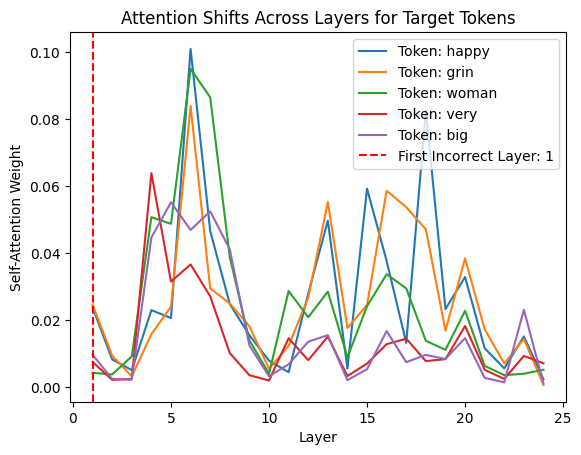

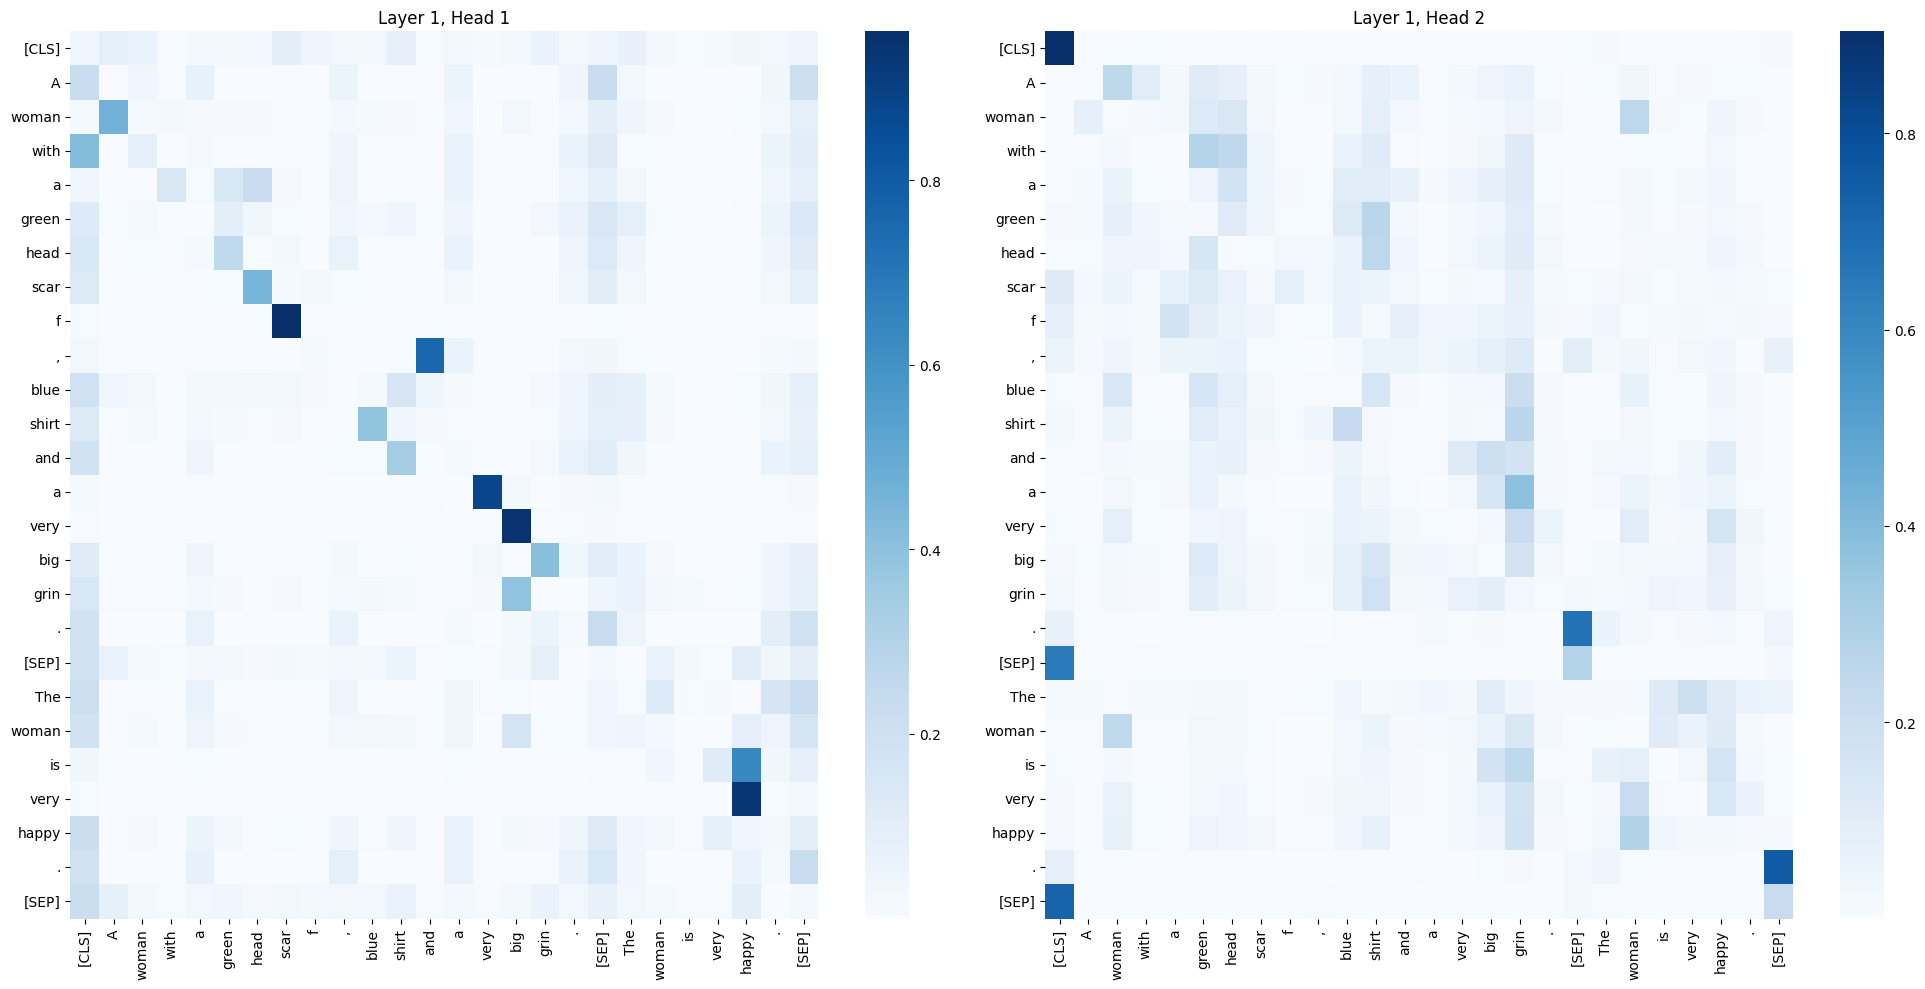

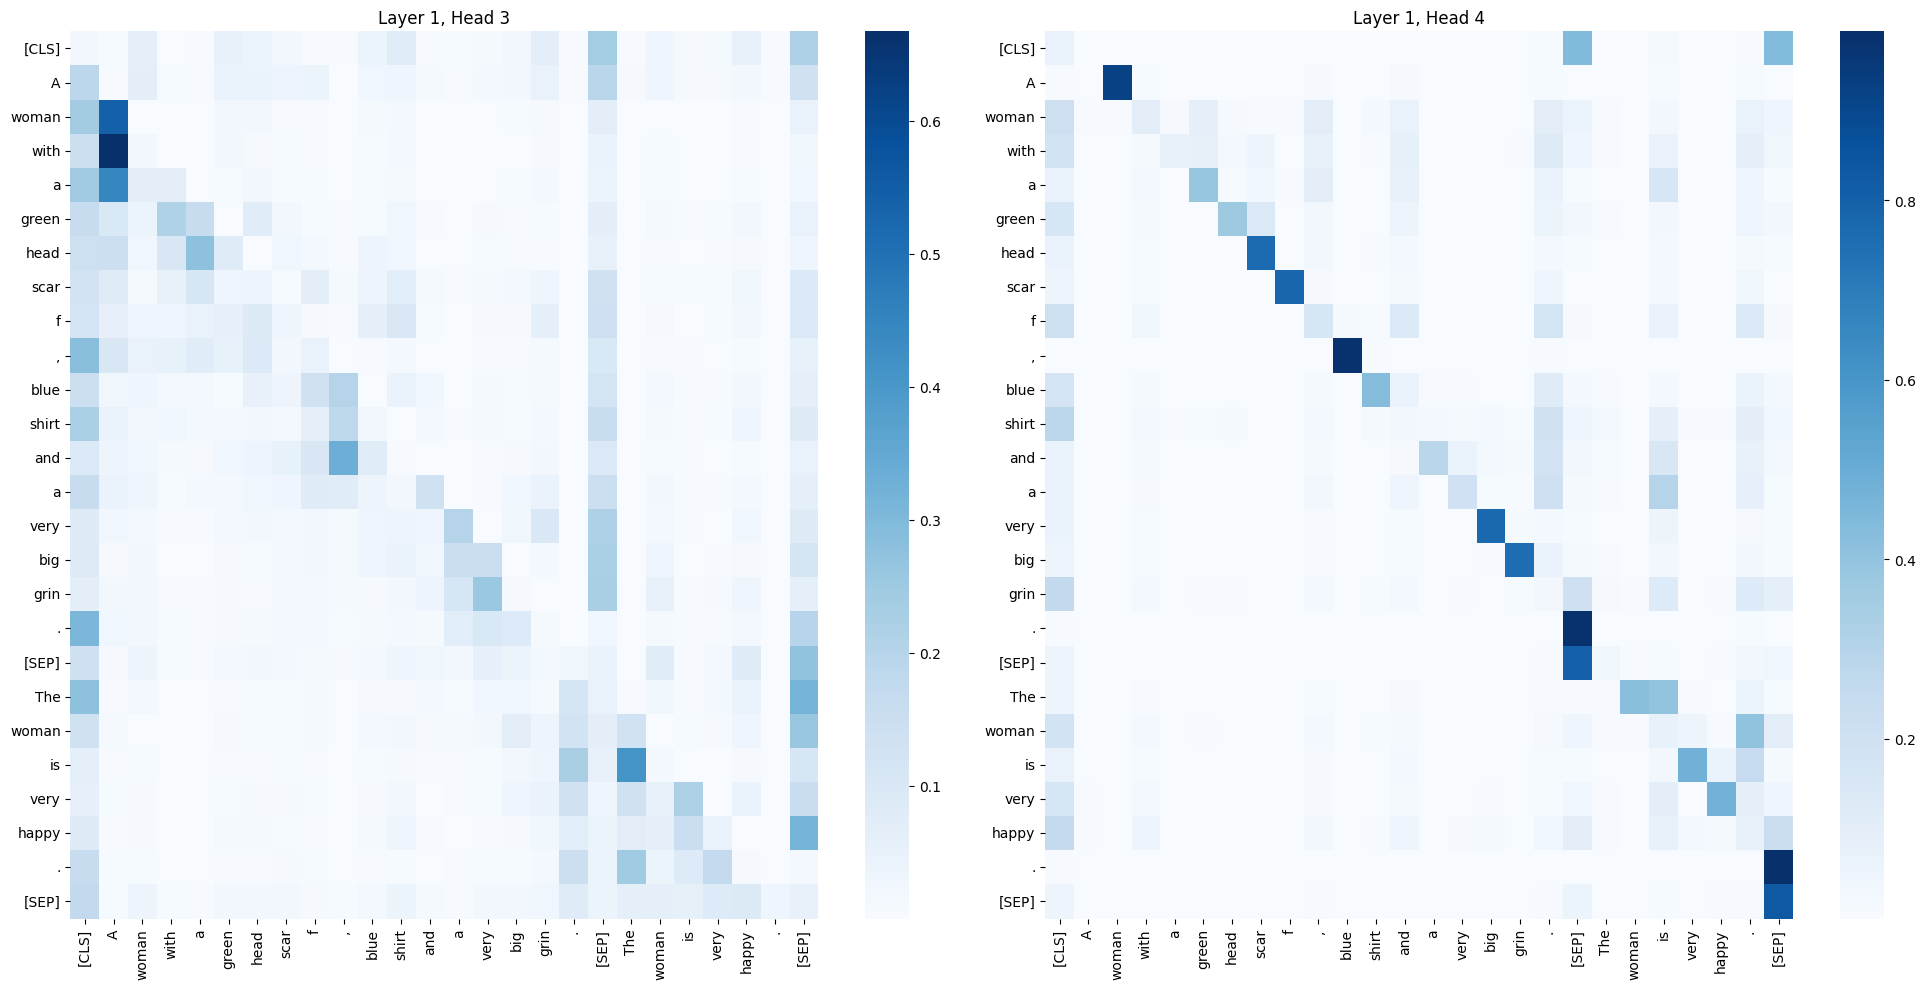

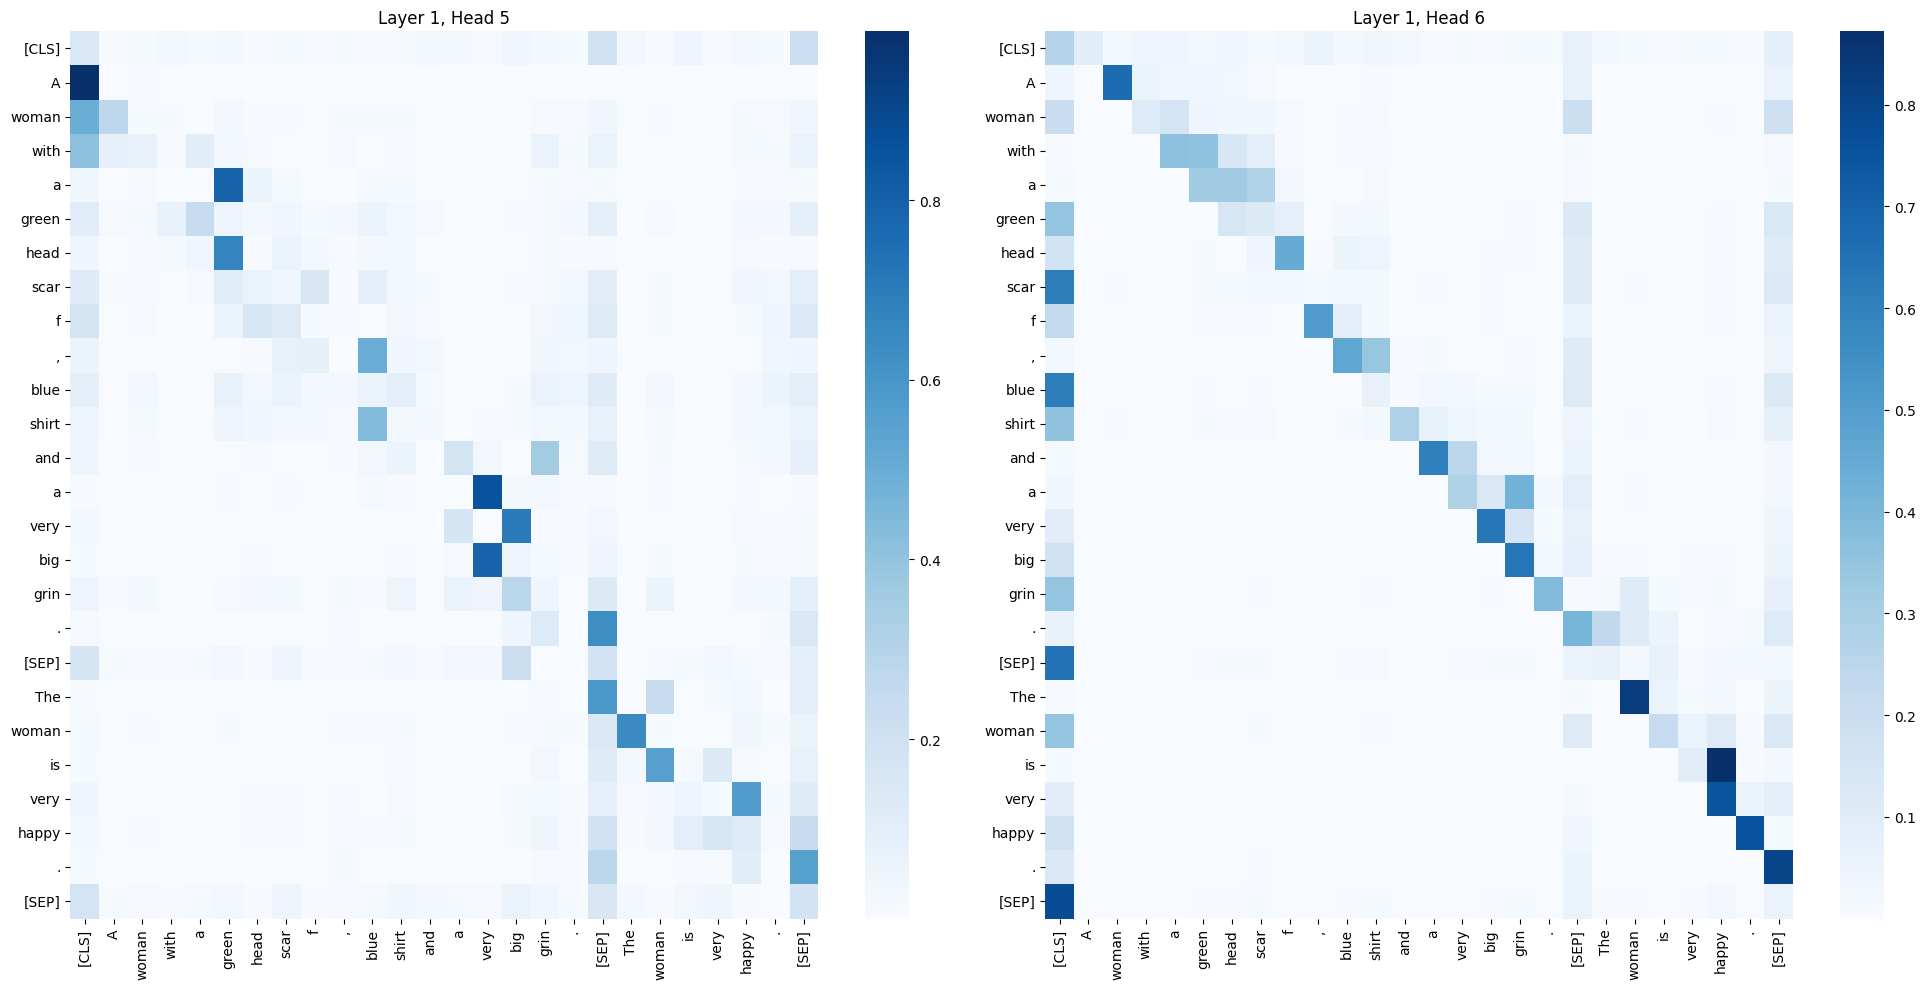

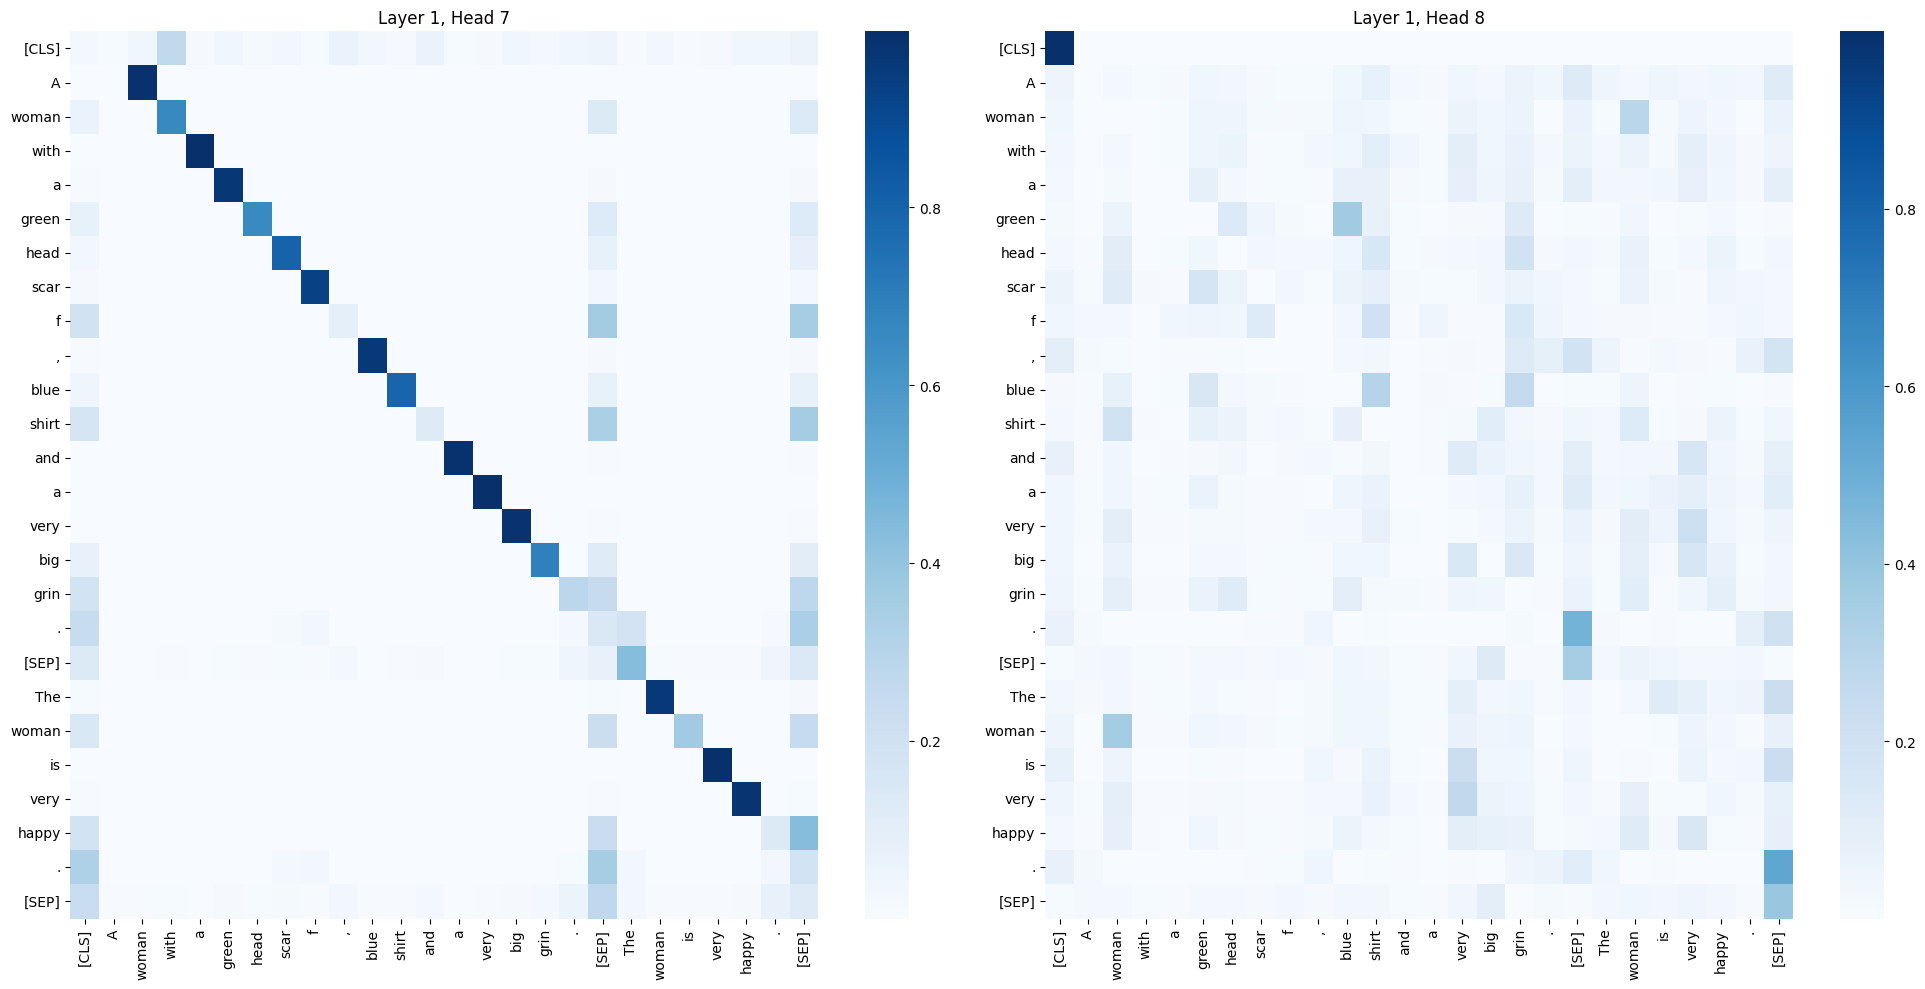

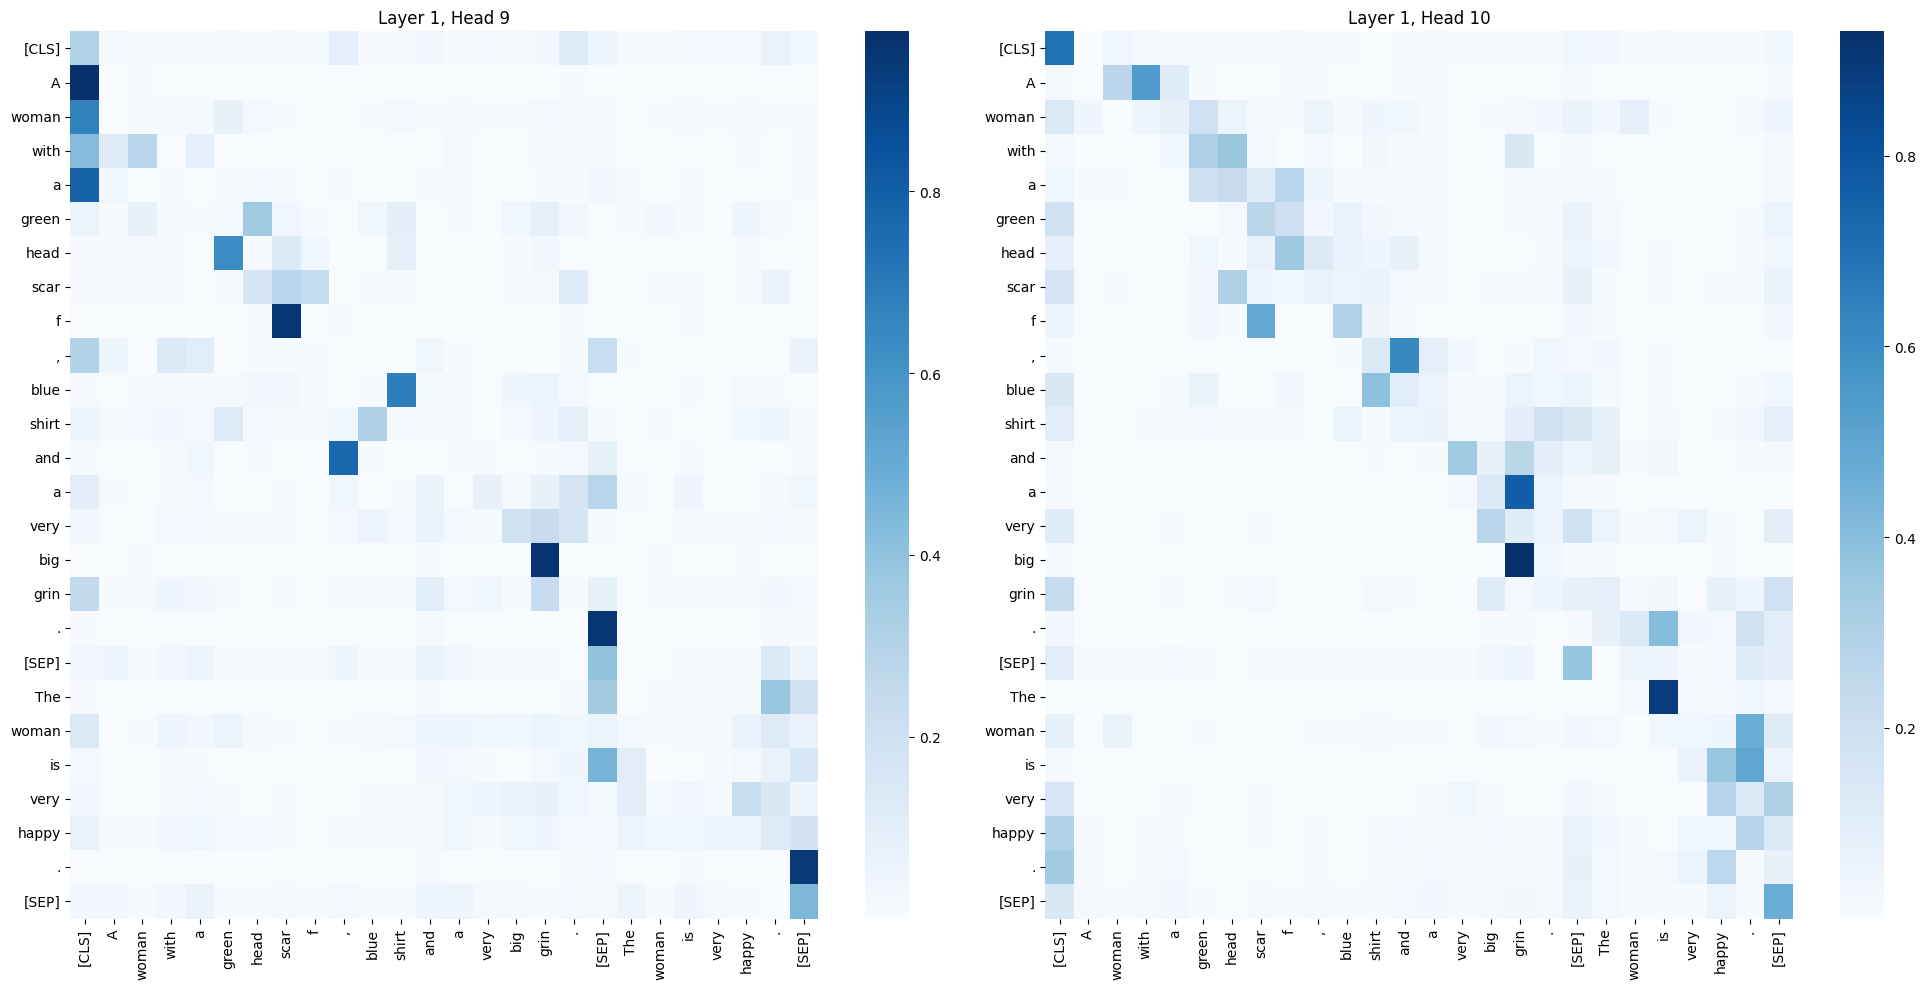

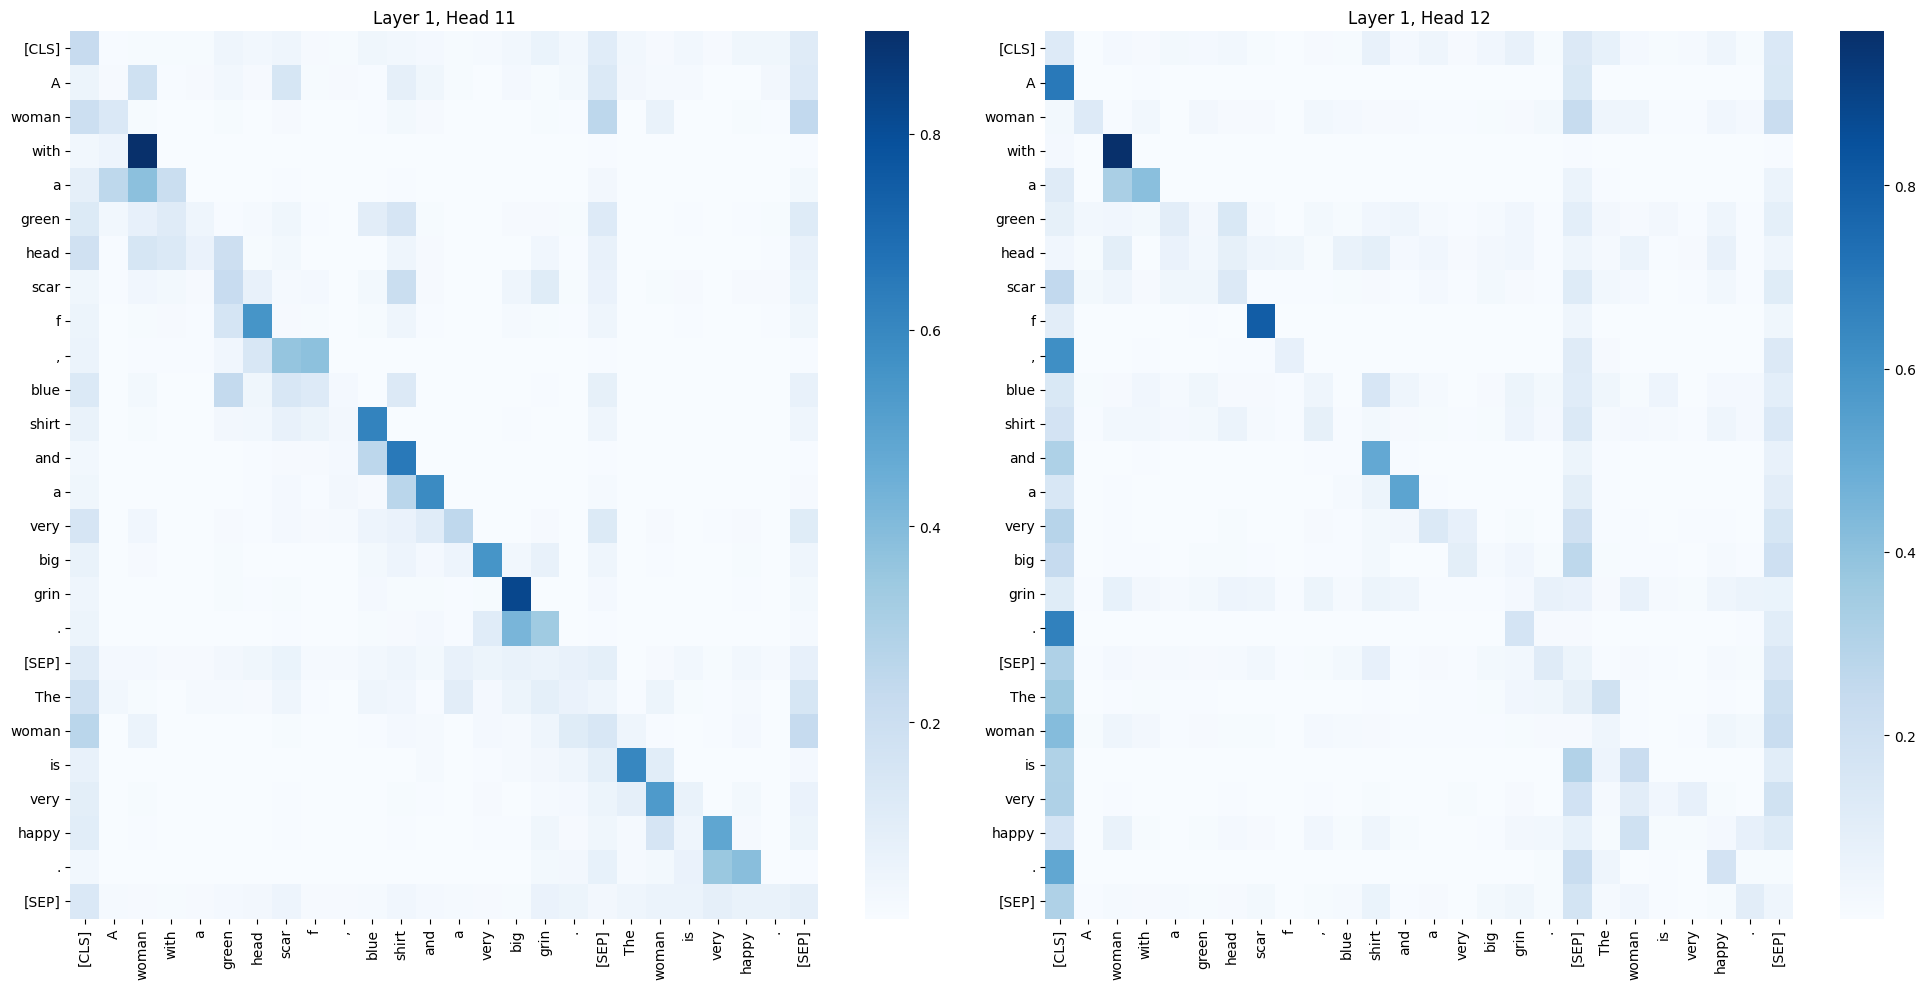

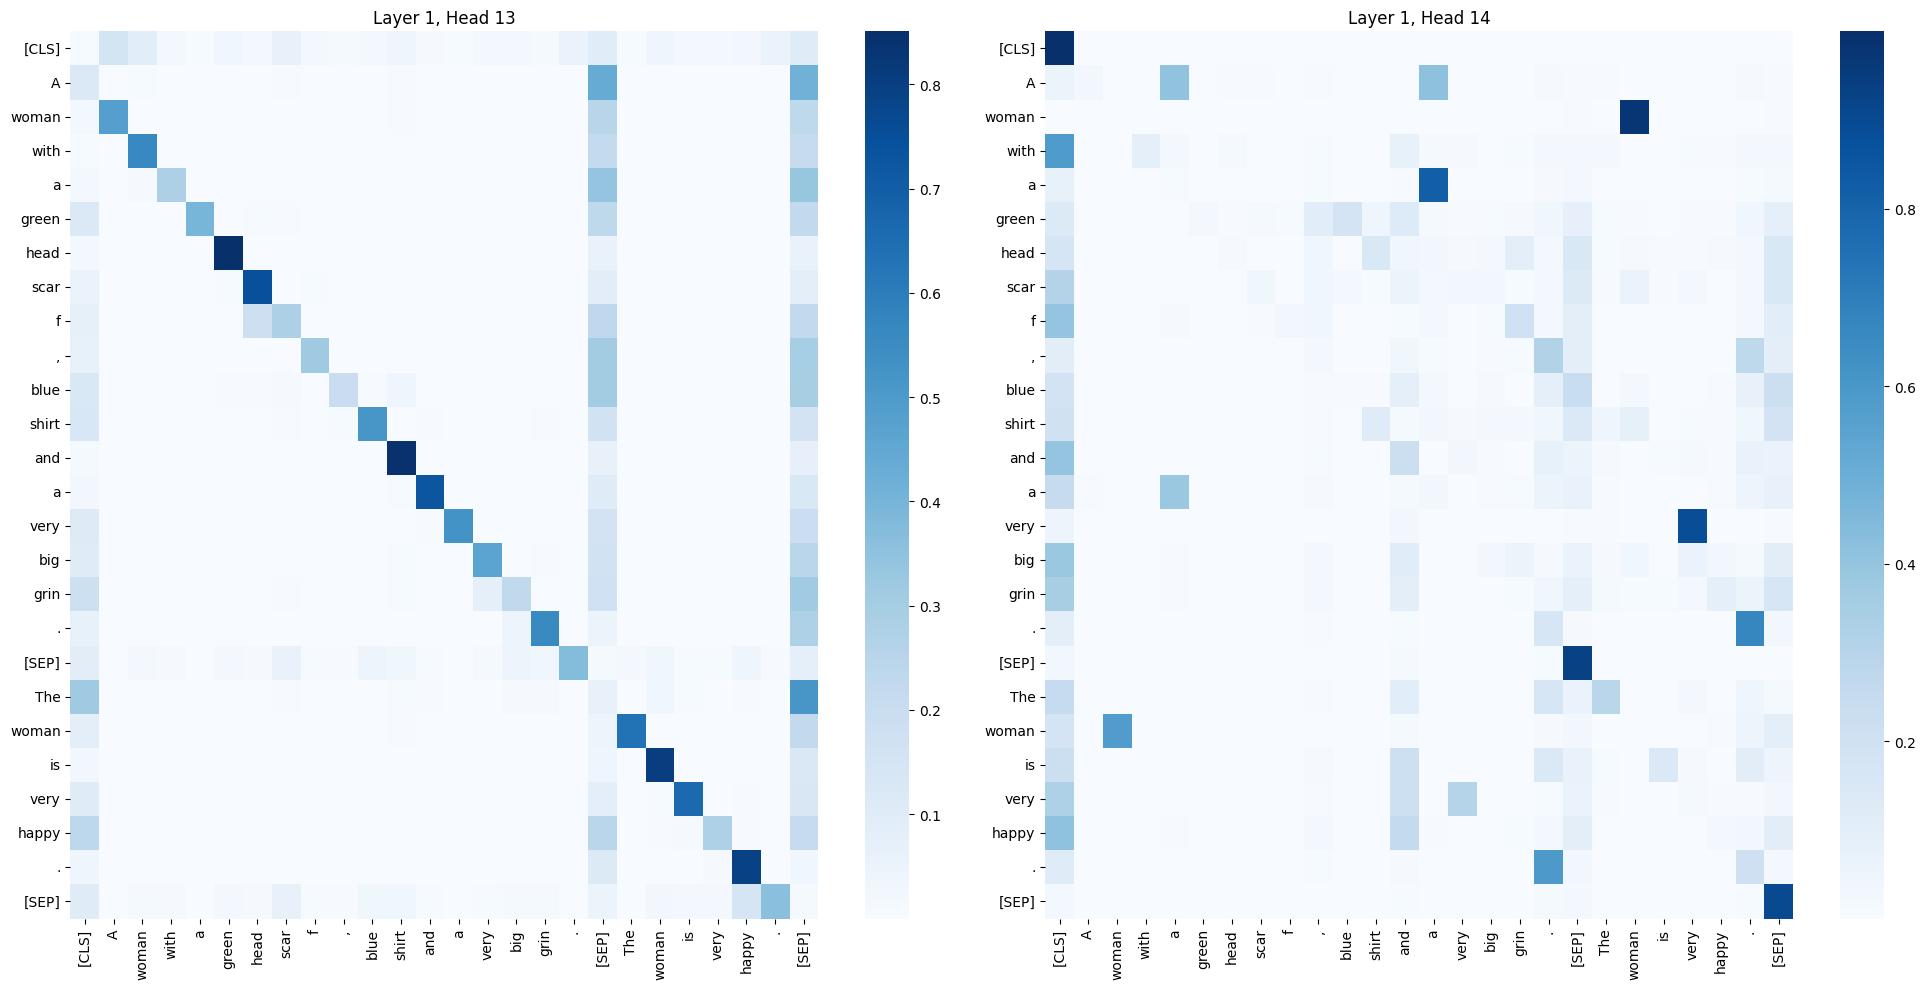

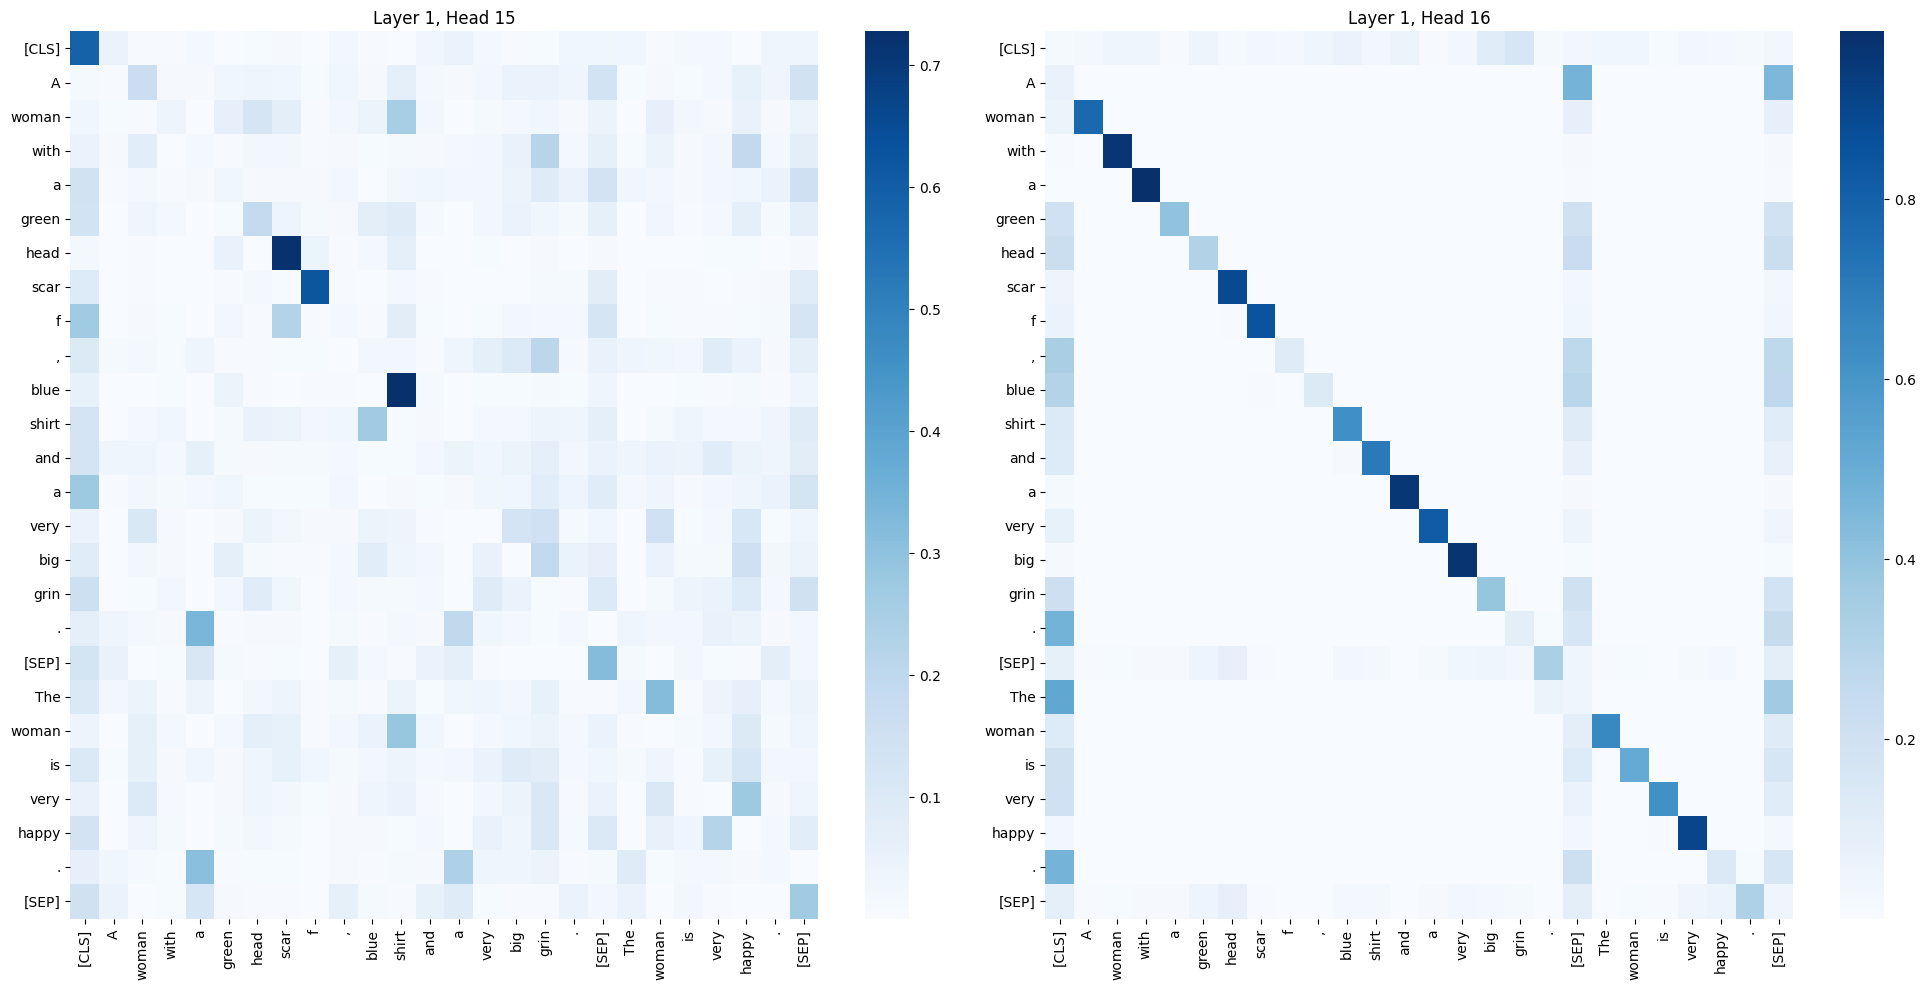

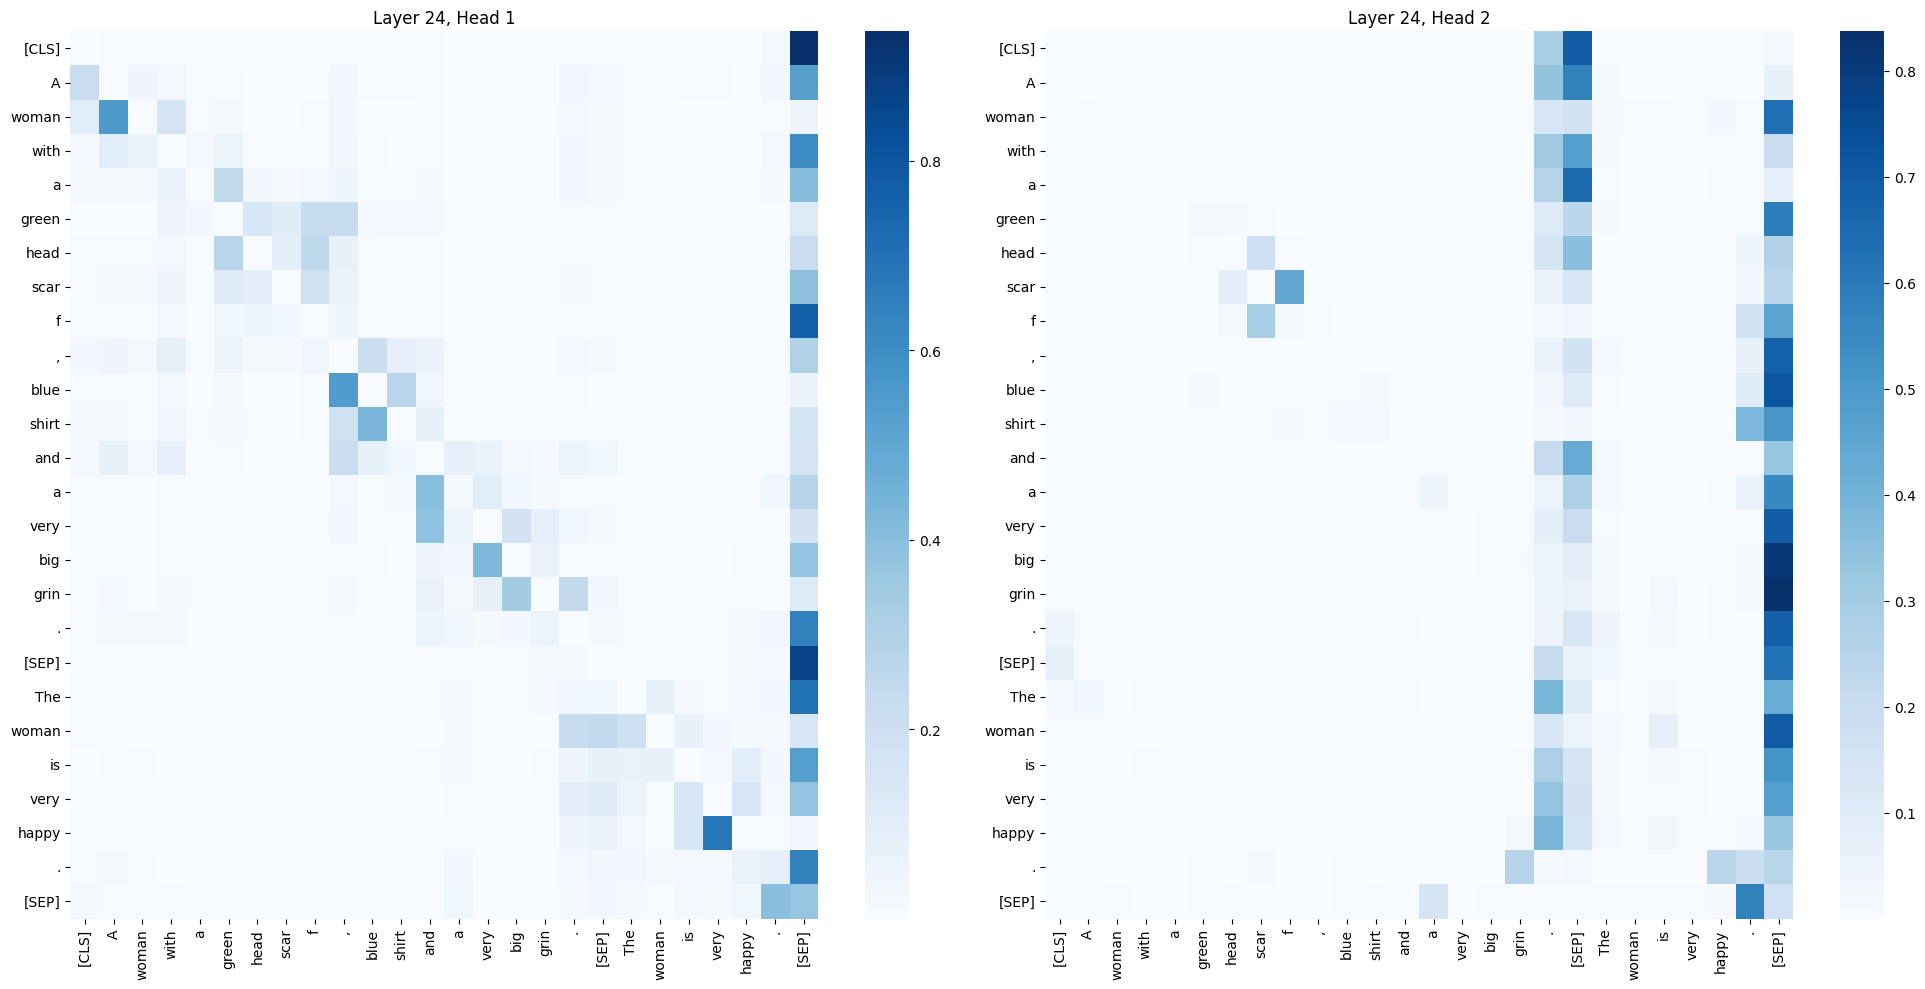

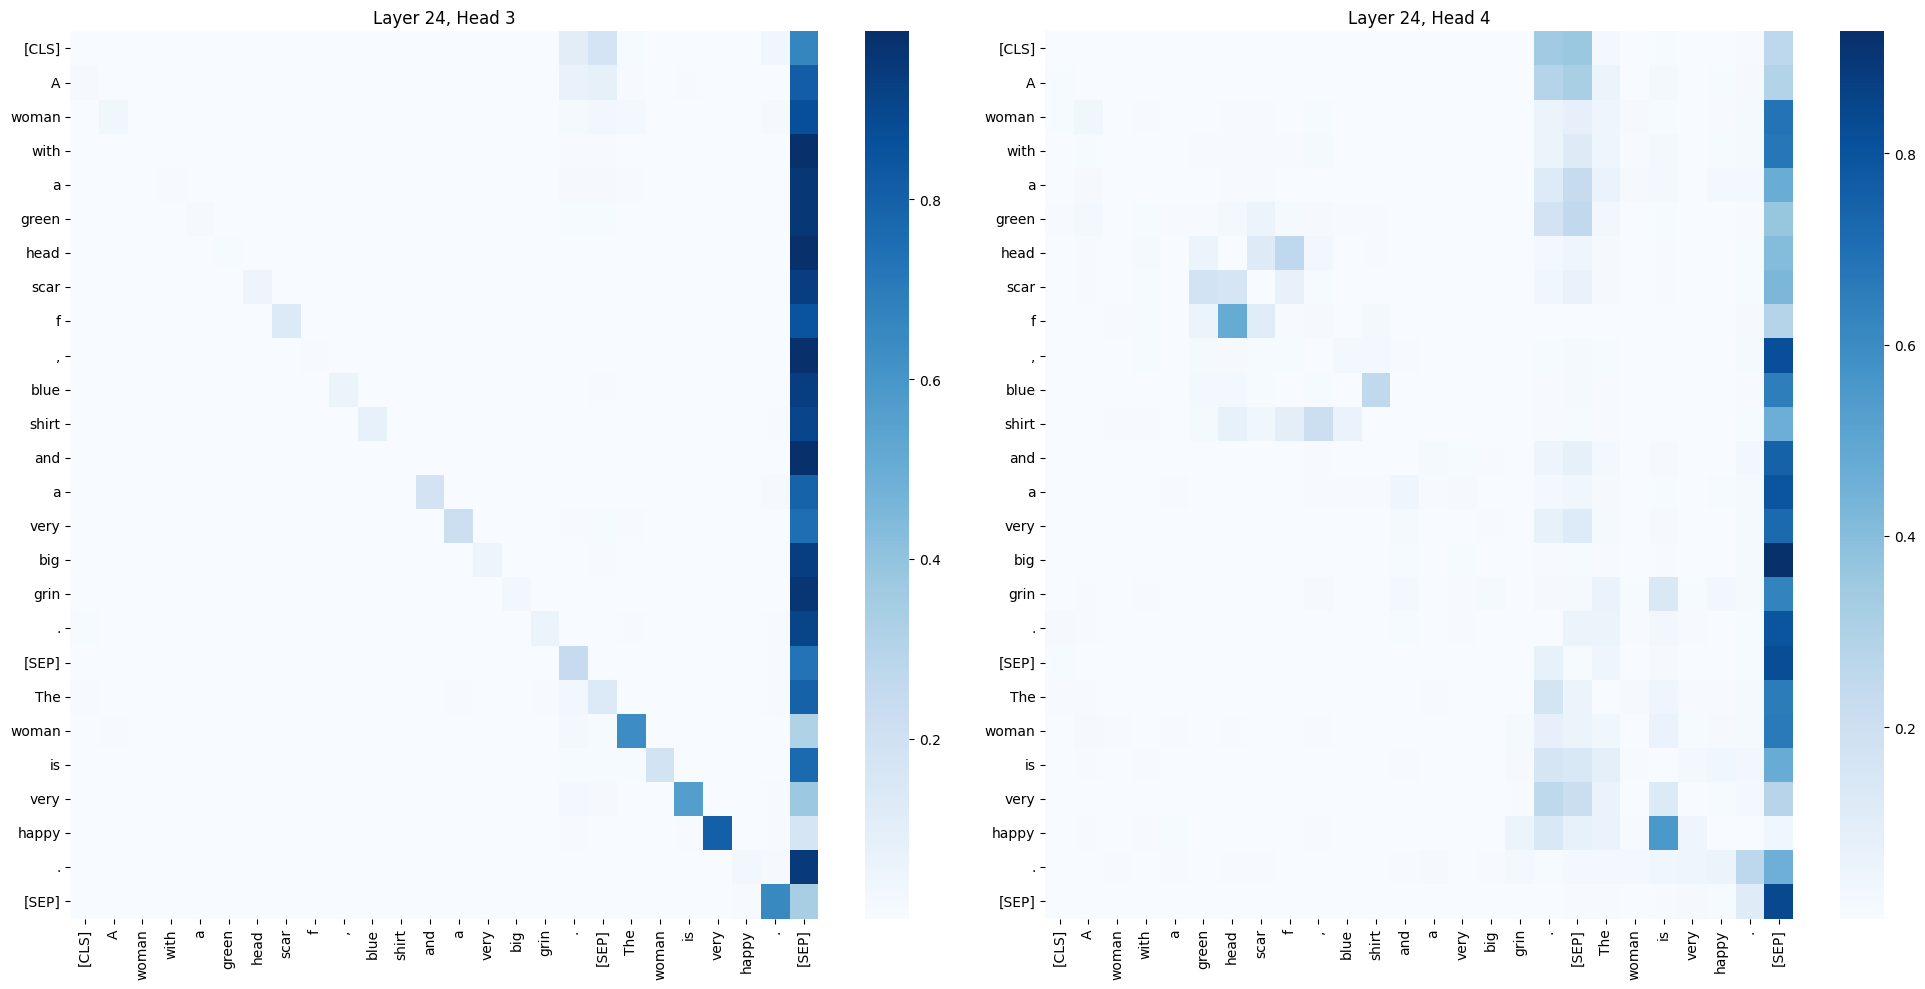

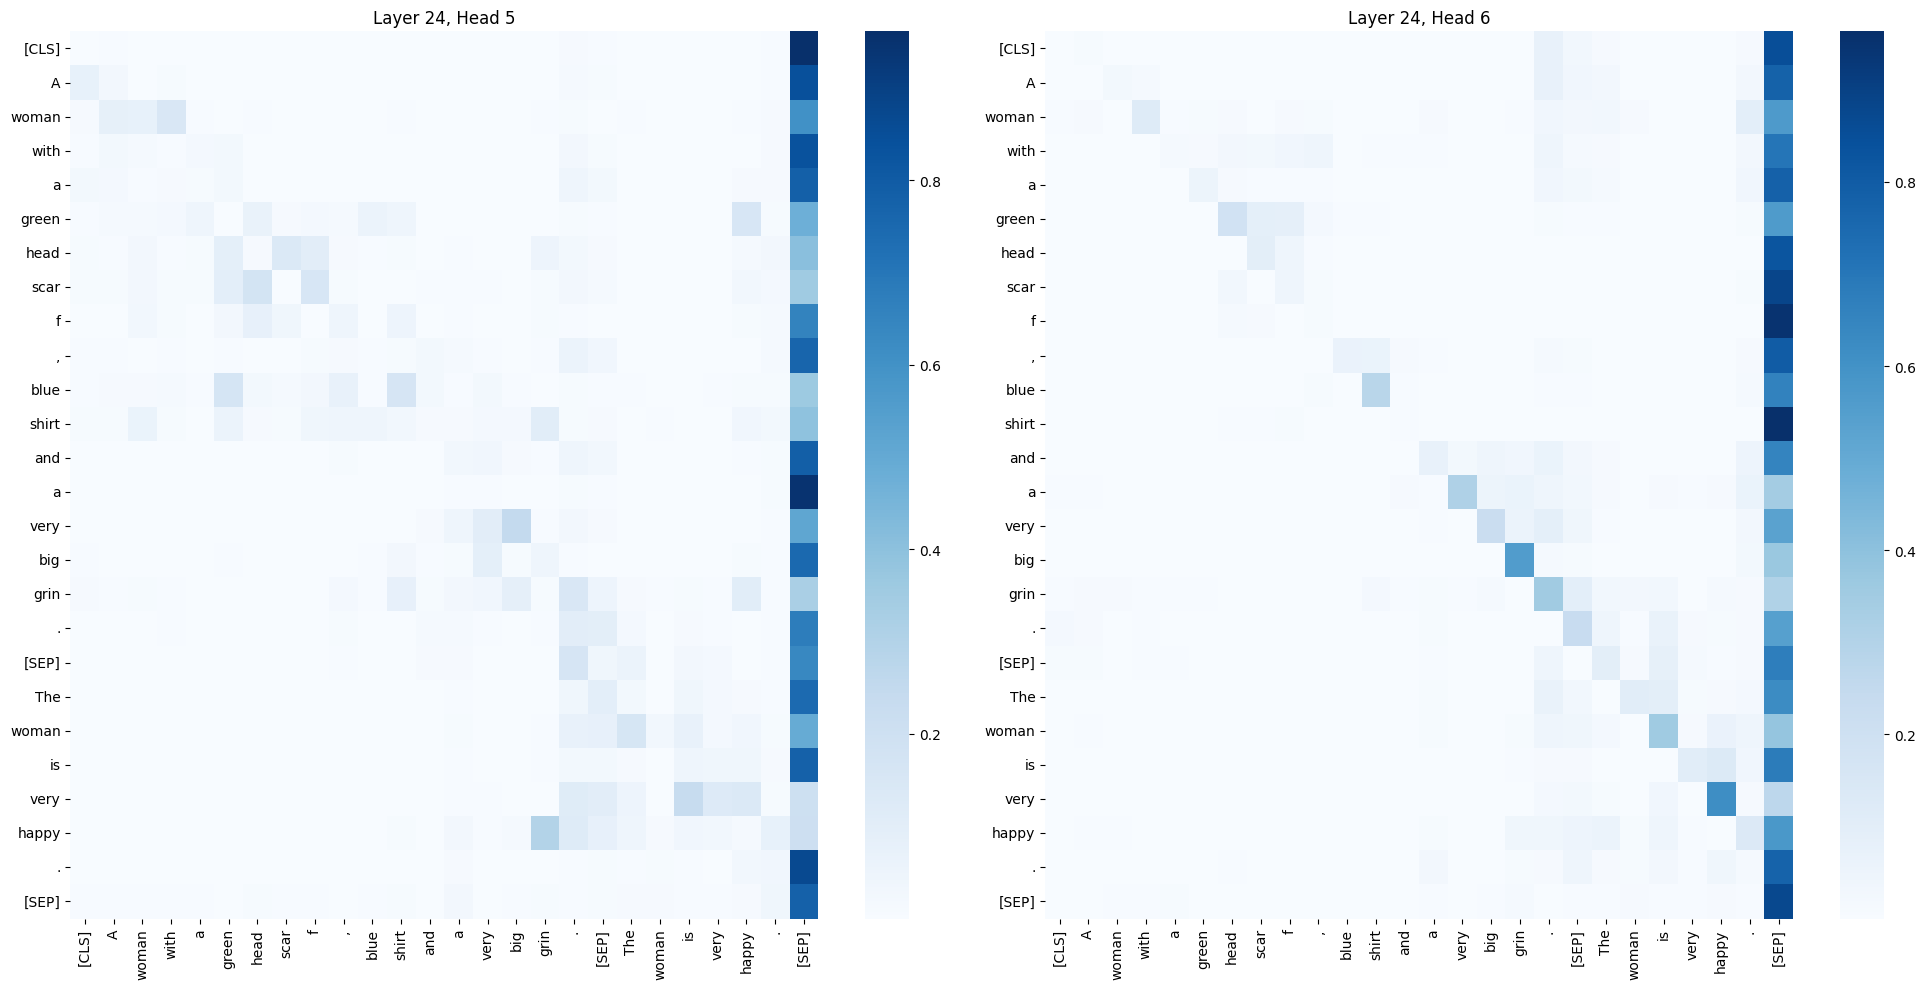

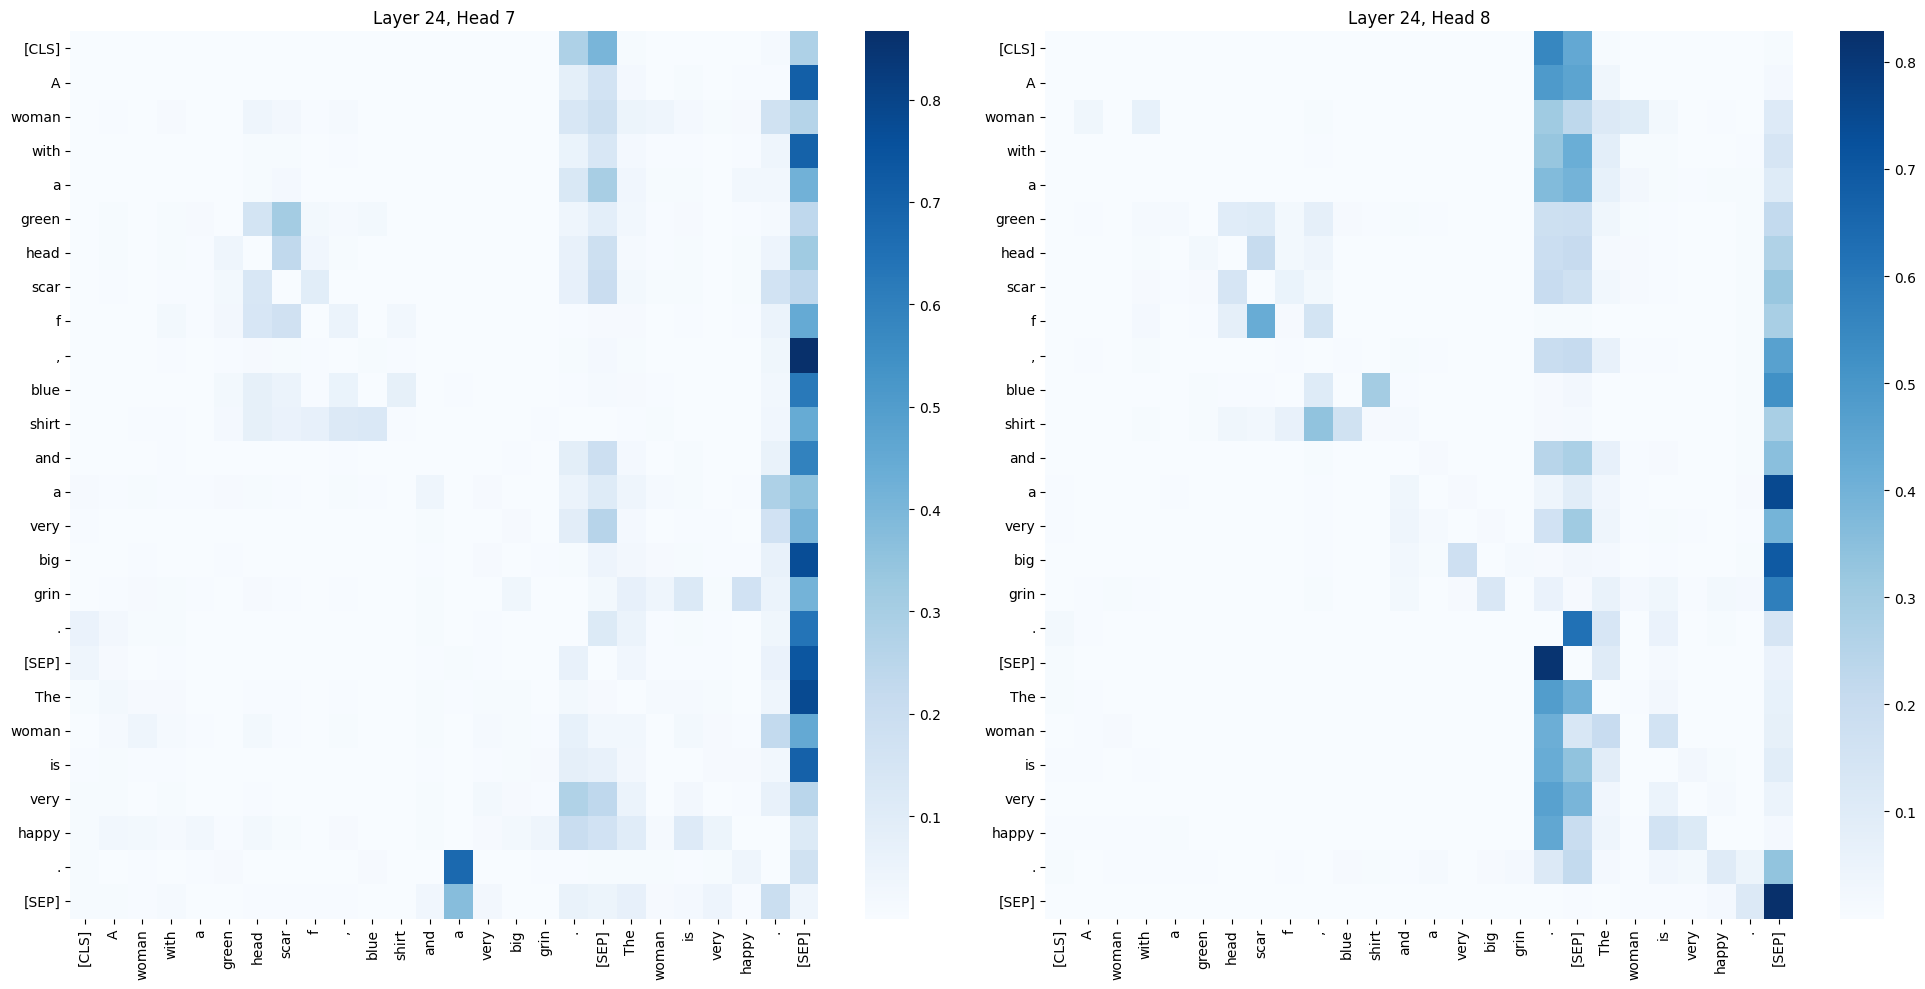

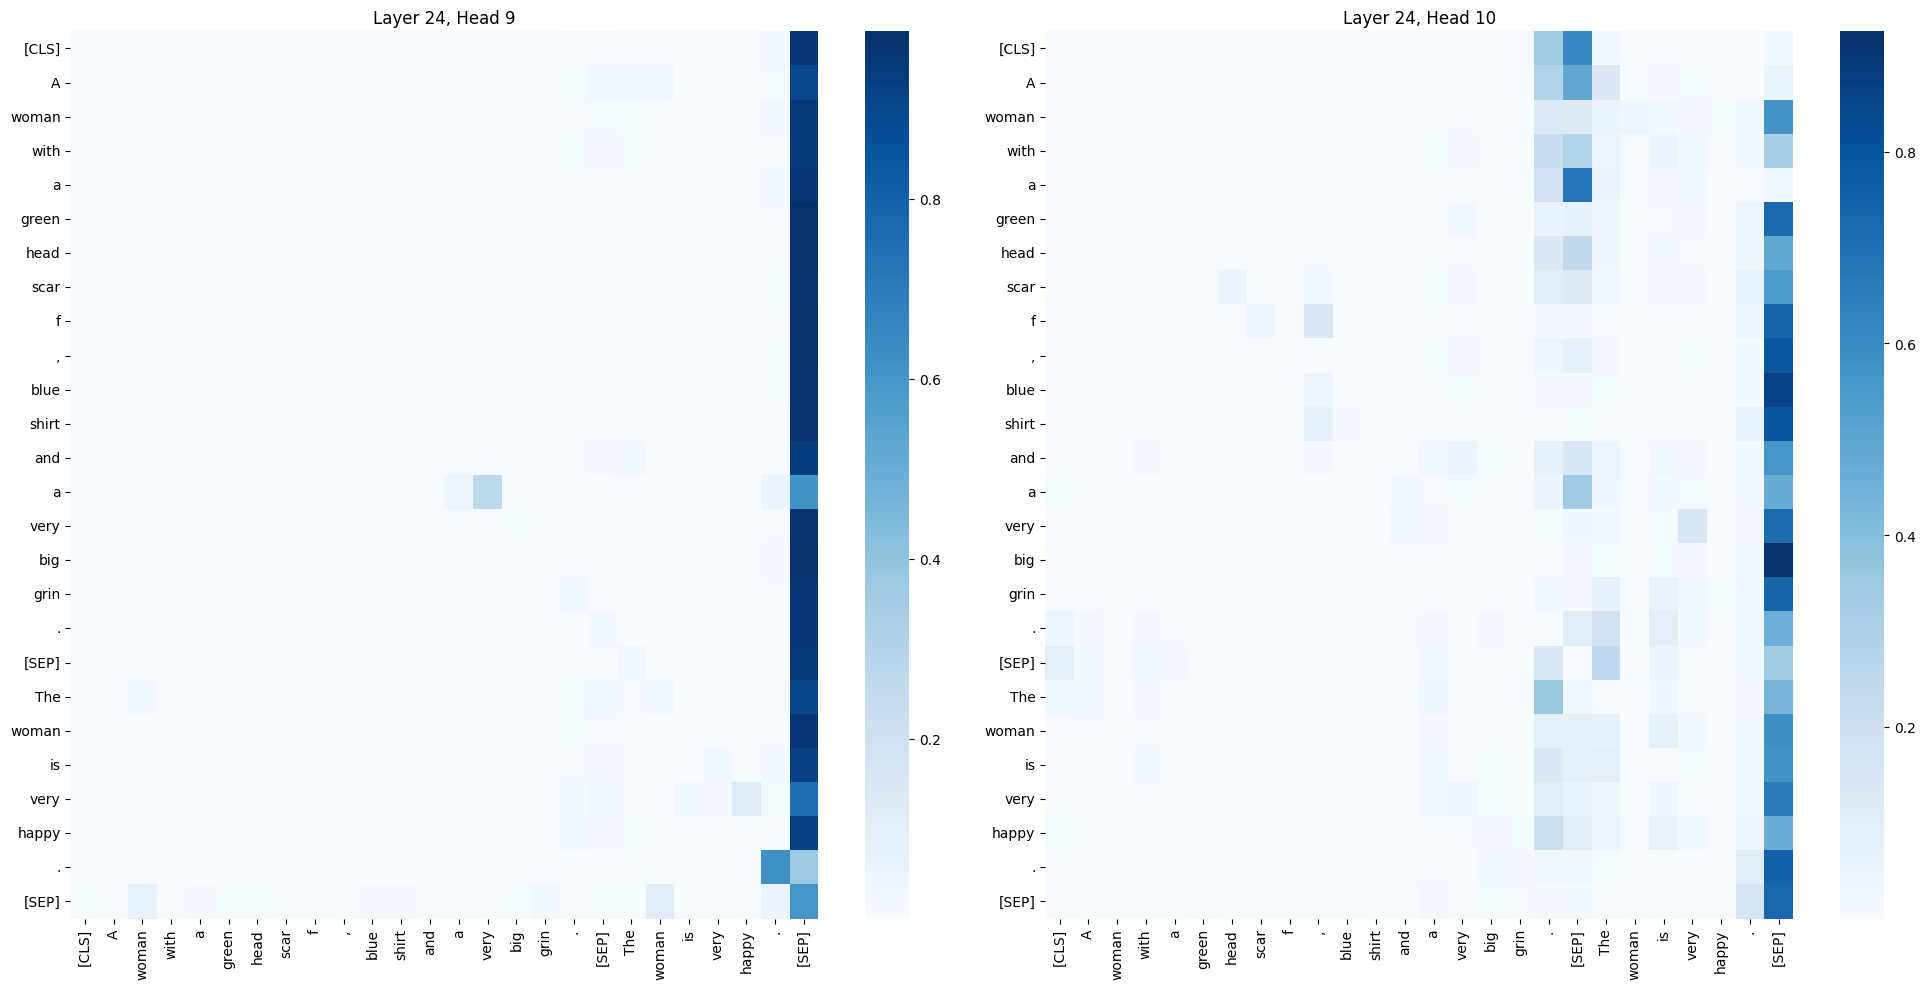

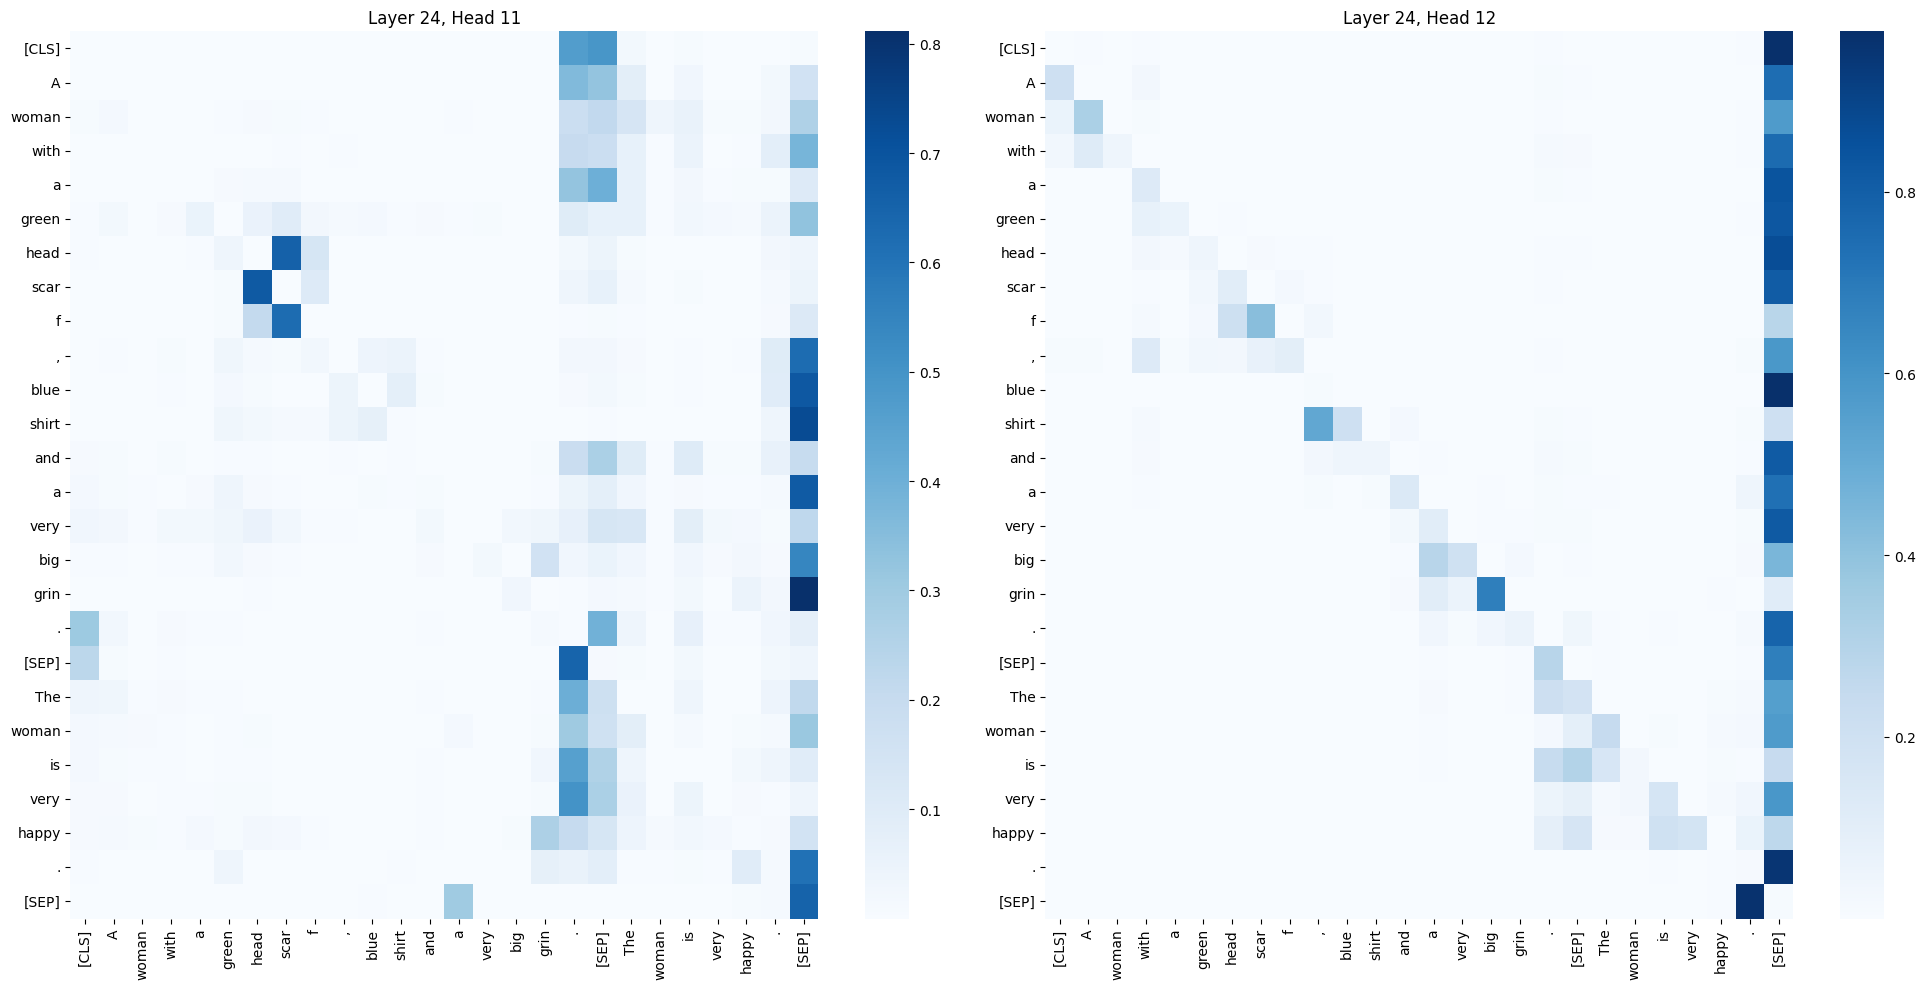

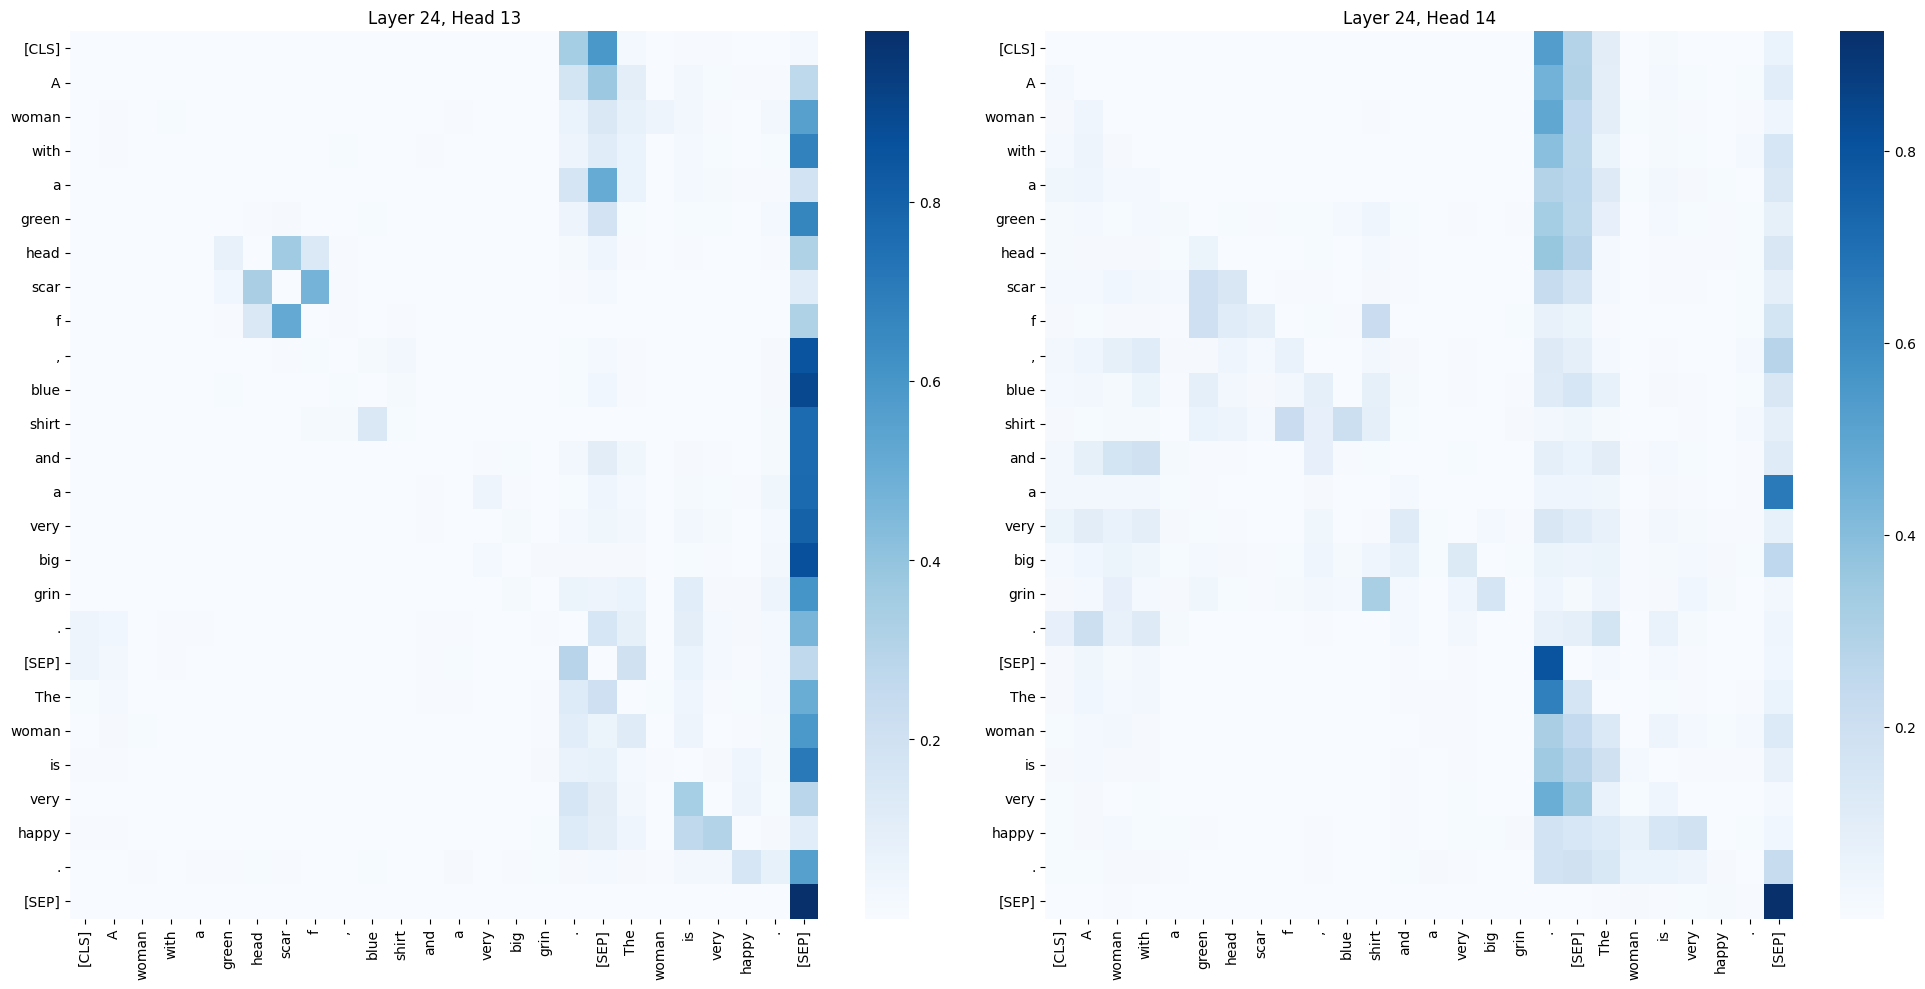

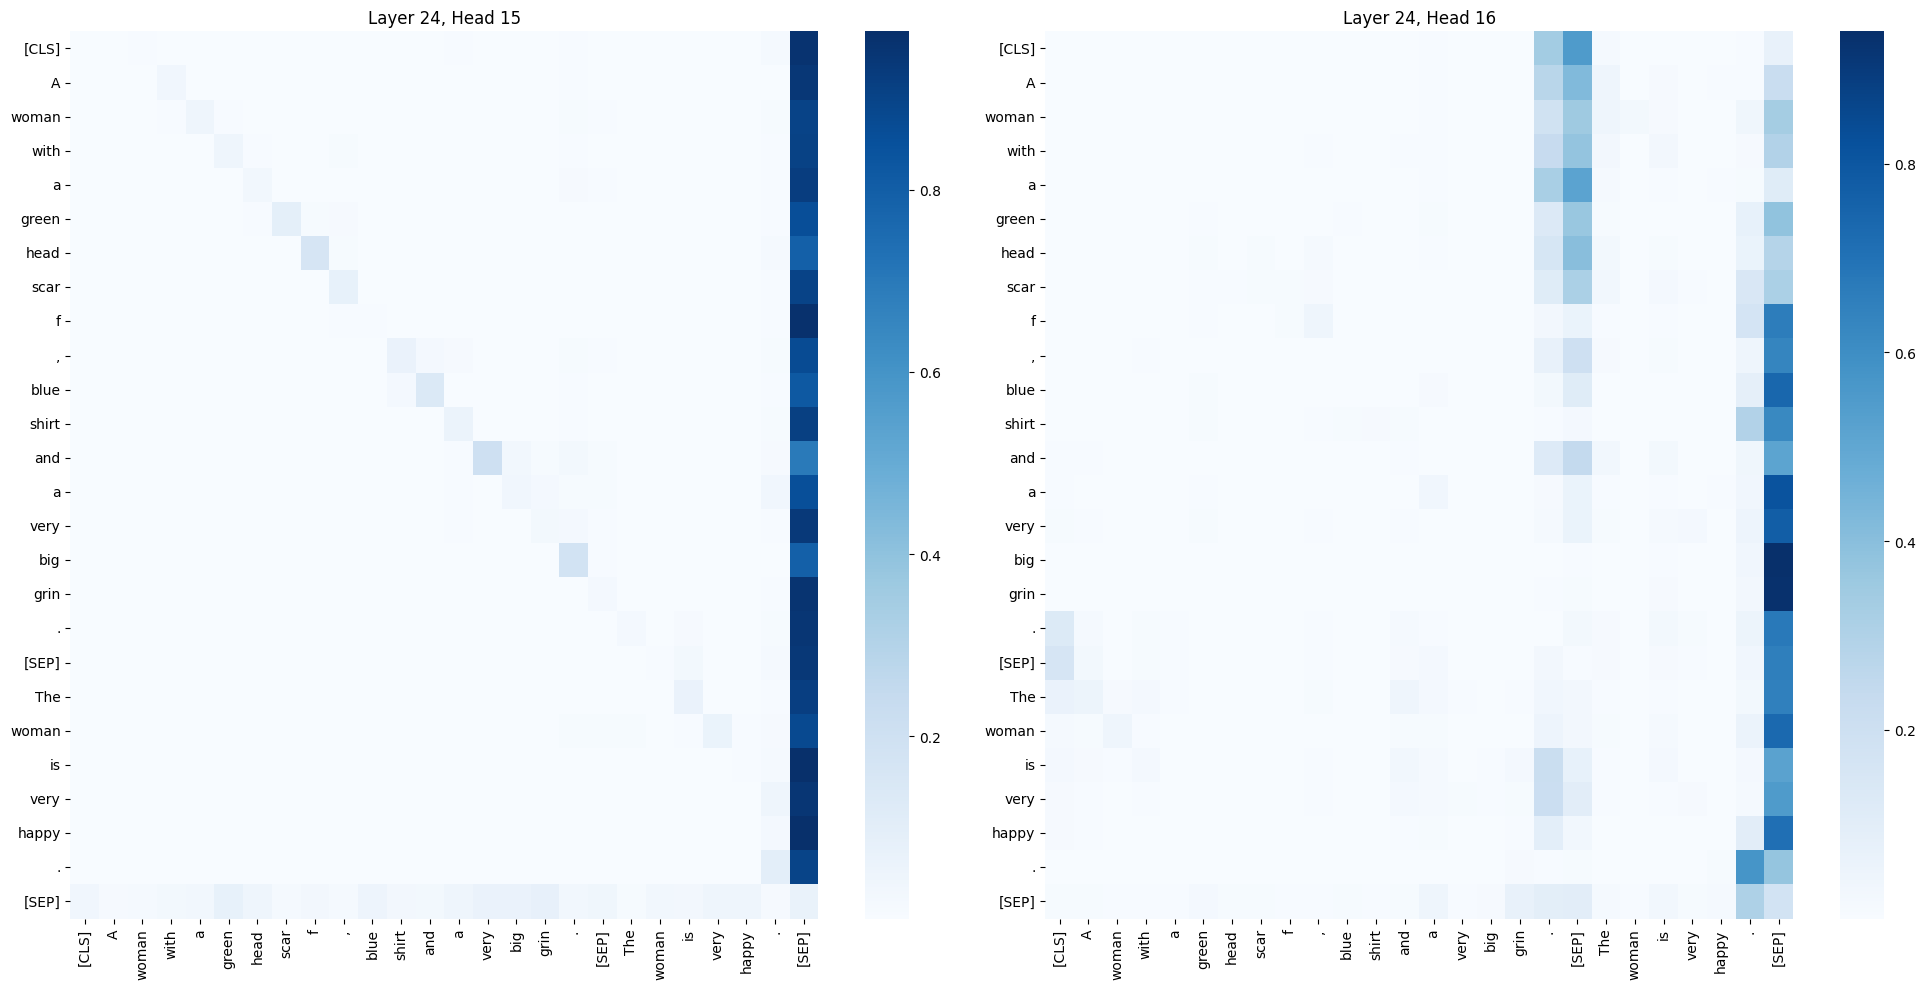

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to clean tokens by removing prefixes
def clean_tokens(tokens):
    cleaned_tokens = []
    for token in tokens:
        if token.startswith("Ġ"):  # Remove leading Ġ in some tokenizers
            token = token[1:]
        cleaned_tokens.append(token)
    return cleaned_tokens

# Function to track attention of specific tokens across layers
def track_attention_on_tokens(attentions, tokens, target_token_indices):
    num_layers = len(attentions)  # Total number of layers
    num_heads = attentions[0].shape[1]  # Total number of attention heads

    # Average attention for each token at each layer
    attention_across_layers = np.zeros((num_layers, len(target_token_indices)))

    # Iterate through each layer
    for layer in range(num_layers):
        attention_avg = attentions[layer].mean(dim=1).squeeze(0).cpu().numpy()  # Average across heads
        for idx, token_idx in enumerate(target_token_indices):
            attention_across_layers[layer, idx] = attention_avg[token_idx, token_idx]  # Self-attention of the token
    
    return attention_across_layers

# Function to explain the model's decision and track attention shifts
def explain_and_track_attention(premise, hypothesis, target_tokens, model, tokenizer):
    inputs = tokenizer(premise, hypothesis, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # Extract attention scores
        hidden_states = outputs.hidden_states  # Extract hidden states for each layer
        final_logits = outputs.logits  # Final logits for the last layer
    
    predicted_label_idx = torch.argmax(final_logits, dim=-1).cpu().item()
    predicted_label = ['contradiction', 'neutral', 'entailment'][predicted_label_idx]
    
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))
    tokens = clean_tokens(tokens)  # Clean tokens
    
    print(f"Model Final Prediction: {predicted_label}")
    
    # Identify where the model starts making incorrect predictions
    label_map = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
    true_label_idx = label_map[sample_text['gold_label']]
    
    incorrect_layer = None
    for layer_idx in range(len(hidden_states)):
        cls_hidden_state = hidden_states[layer_idx][:, 0, :]
        intermediate_logits = model.classifier(cls_hidden_state)
        predicted_label_at_layer = torch.argmax(intermediate_logits, dim=-1).cpu().item()
        
        if predicted_label_at_layer != true_label_idx:
            incorrect_layer = layer_idx + 1  # First incorrect layer
            print(f"First incorrect prediction at Layer {incorrect_layer}")
            break
    
    if incorrect_layer is None:
        print("Model makes correct predictions in all layers.")
        incorrect_layer = len(hidden_states)  # Last layer if the model is correct throughout

    target_token_indices = [tokens.index(token) for token in target_tokens if token in tokens]
    attention_across_layers = track_attention_on_tokens(attentions, tokens, target_token_indices)
    
    for idx, token in enumerate(target_tokens):
        if token in tokens:
            plt.plot(range(1, len(attentions) + 1), attention_across_layers[:, idx], label=f"Token: {token}")
    
    plt.axvline(x=incorrect_layer, color='r', linestyle='--', label=f"First Incorrect Layer: {incorrect_layer}")
    plt.xlabel("Layer")
    plt.ylabel("Self-Attention Weight")
    plt.title("Attention Shifts Across Layers for Target Tokens")
    plt.legend()
    plt.show()

    # Heatmaps for attention across all heads
    if incorrect_layer:
        visualize_attention_heads(attentions, tokens, layer=incorrect_layer - 1, heads_per_figure=2)
    visualize_attention_heads(attentions, tokens, layer=len(attentions) - 1, heads_per_figure=2)

# Function to visualize attention across all heads in one layer, 2 heads per figure
def visualize_attention_heads(attentions, tokens, layer=0, heads_per_figure=2):
    tokens = clean_tokens(tokens)  # Clean tokens before visualization
    num_heads = attentions[layer].shape[1]  # Number of attention heads
    
    # Iterate over heads
    for i in range(0, num_heads, heads_per_figure):
        fig, axs = plt.subplots(1, heads_per_figure, figsize=(20, 10))
        
        for j in range(min(heads_per_figure, num_heads - i)):  # Ensure we don't exceed number of heads
            head = i + j
            attention = attentions[layer][0, head].cpu().numpy()  # Extract attention for the specific head
            sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap="Blues", annot=False, ax=axs[j])
            axs[j].set_title(f"Layer {layer + 1}, Head {head + 1}")
            axs[j].tick_params(axis='x', rotation=90)
            axs[j].tick_params(axis='y', rotation=0)
        
        plt.tight_layout()
        plt.show()

# Sample data
sample_number = 5
sample_text = df_snli.iloc[sample_number - 1]  # Subtract 1 because DataFrame is zero-indexed
premise = sample_text['sentence1']
hypothesis = sample_text['sentence2']

# Target tokens to track ("happy", "grin", "woman", "very", "big")
target_tokens = ["happy", "grin", "woman", "very", "big"]

# Analyze and visualize attention distribution and track attention on specific tokens
explain_and_track_attention(premise, hypothesis, target_tokens, model, tokenizer)


Model Final Prediction: entailment


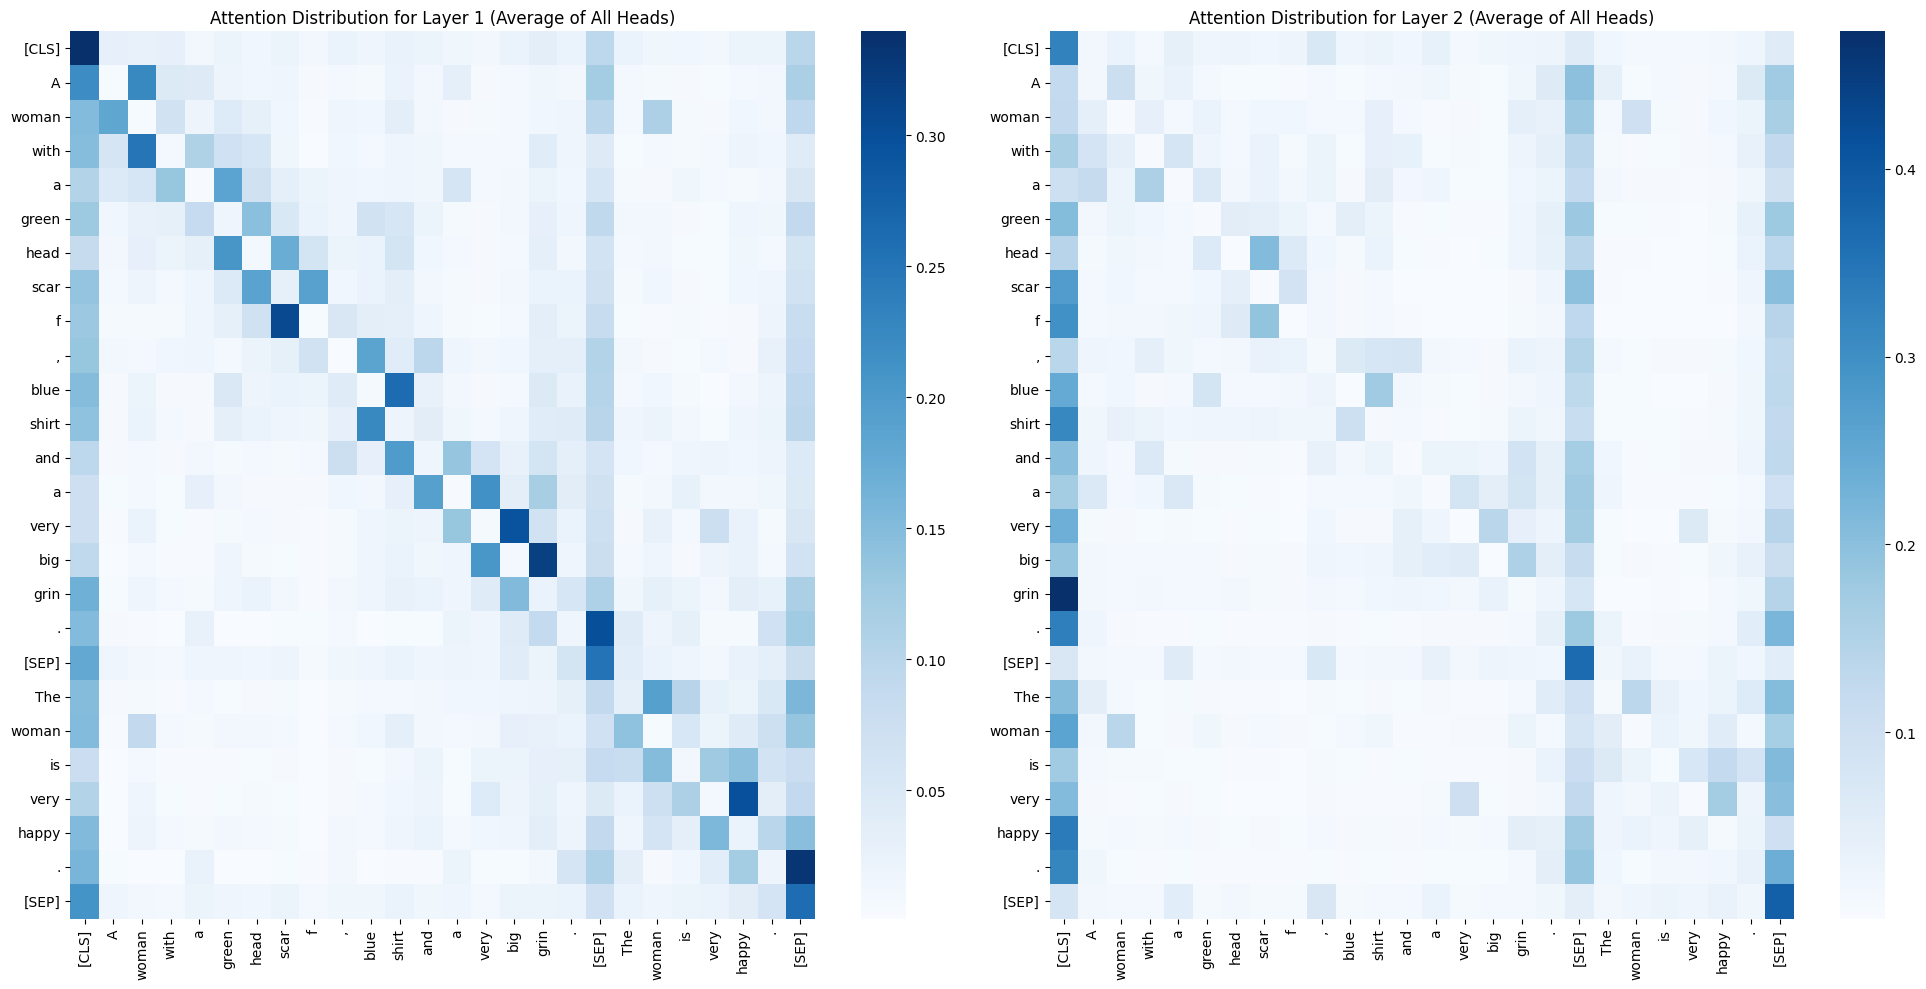

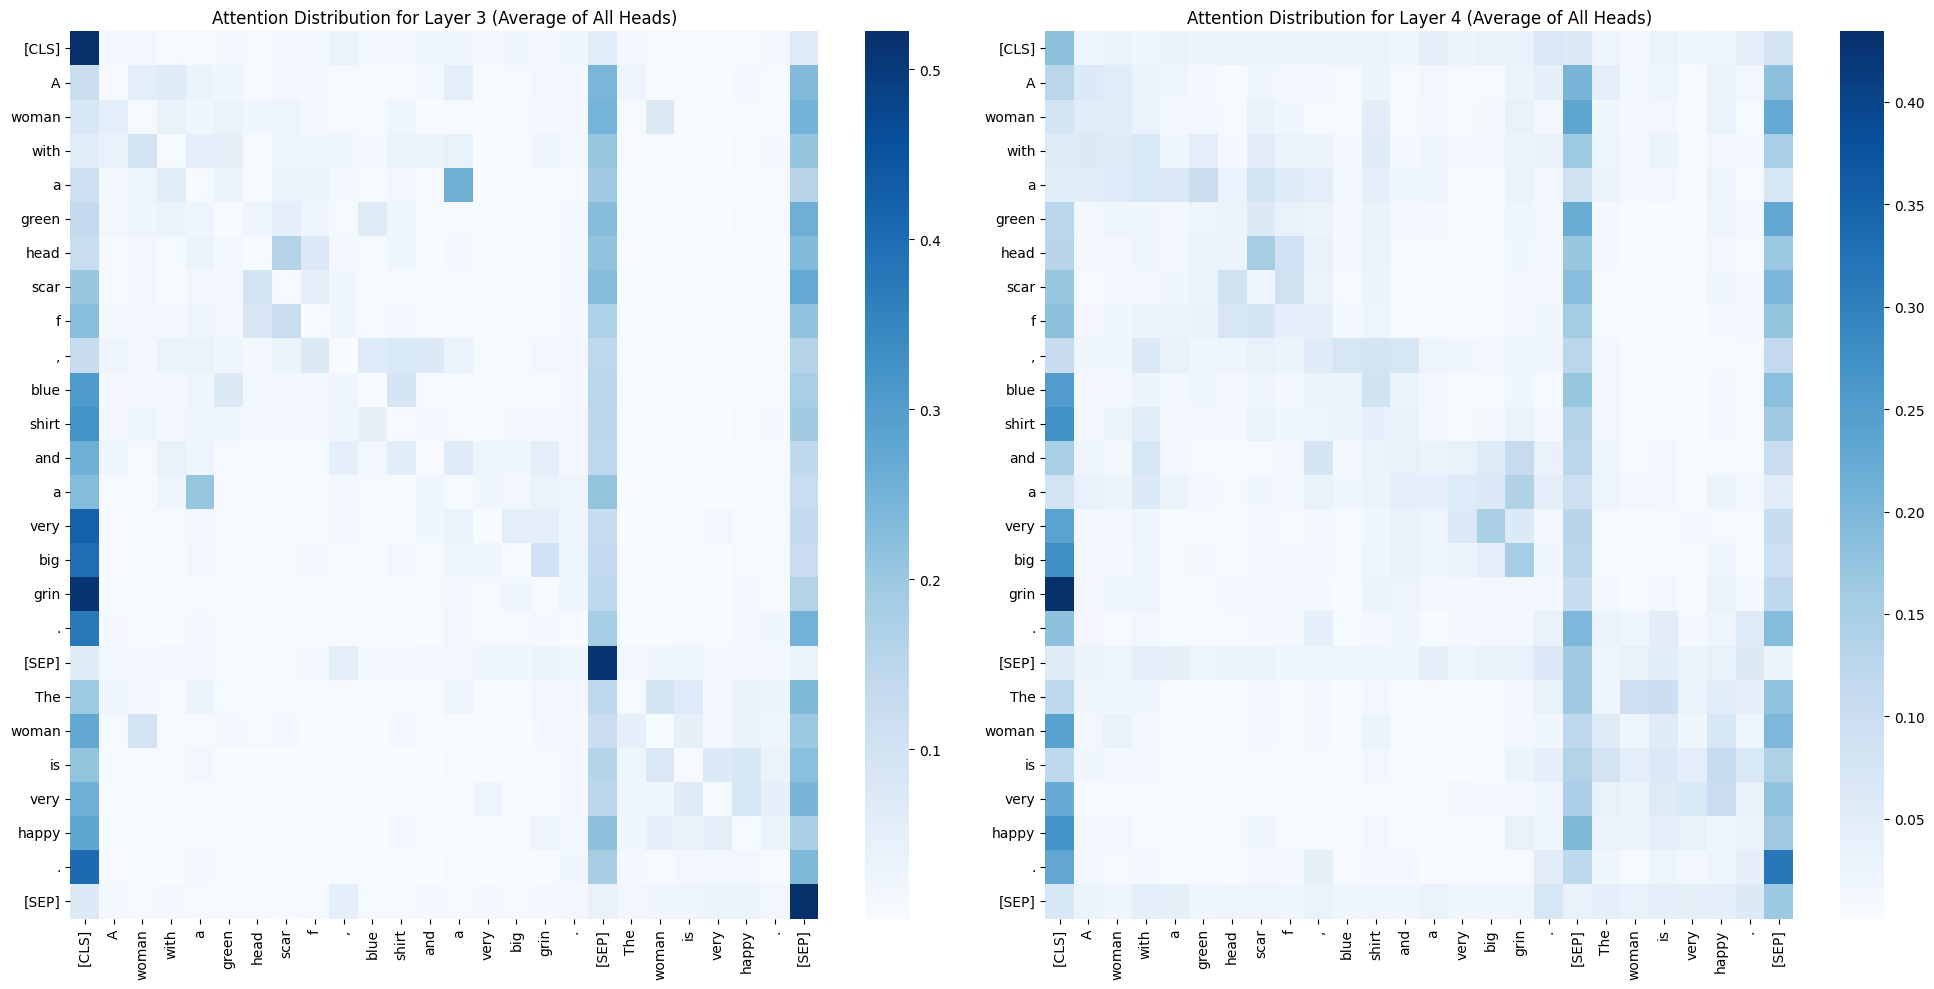

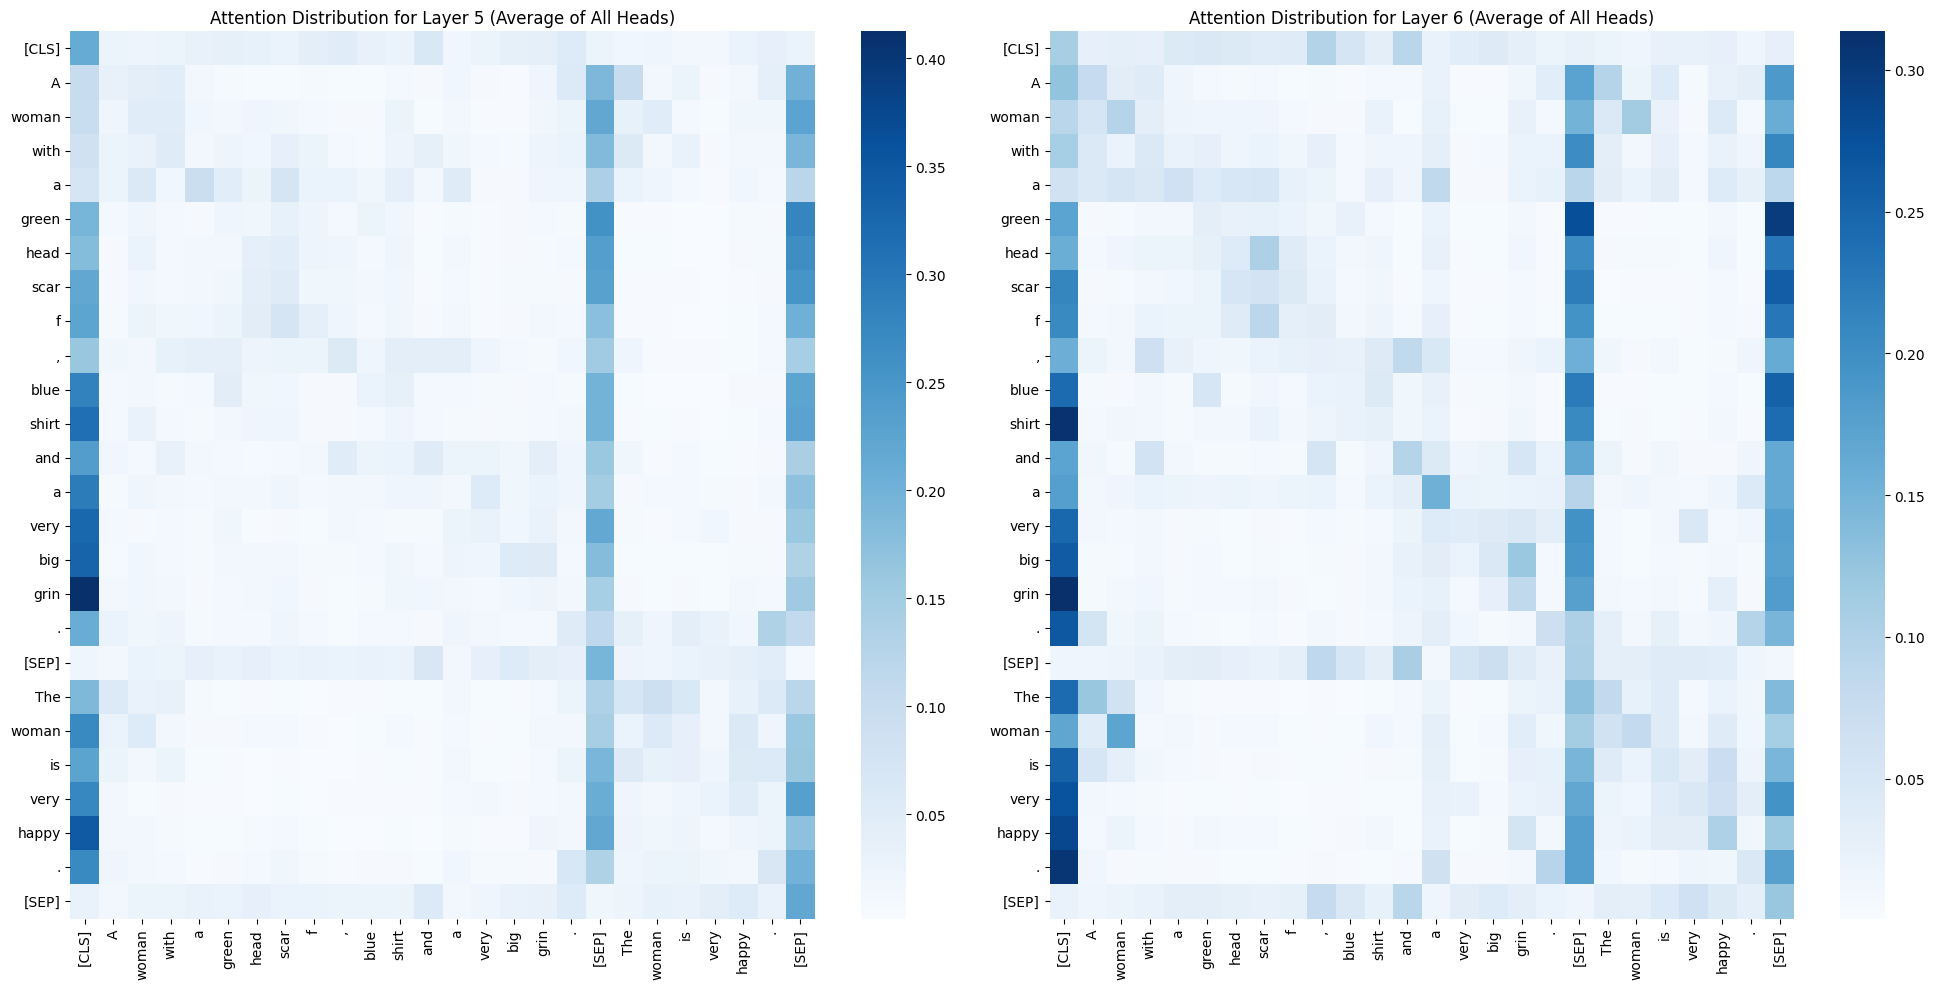

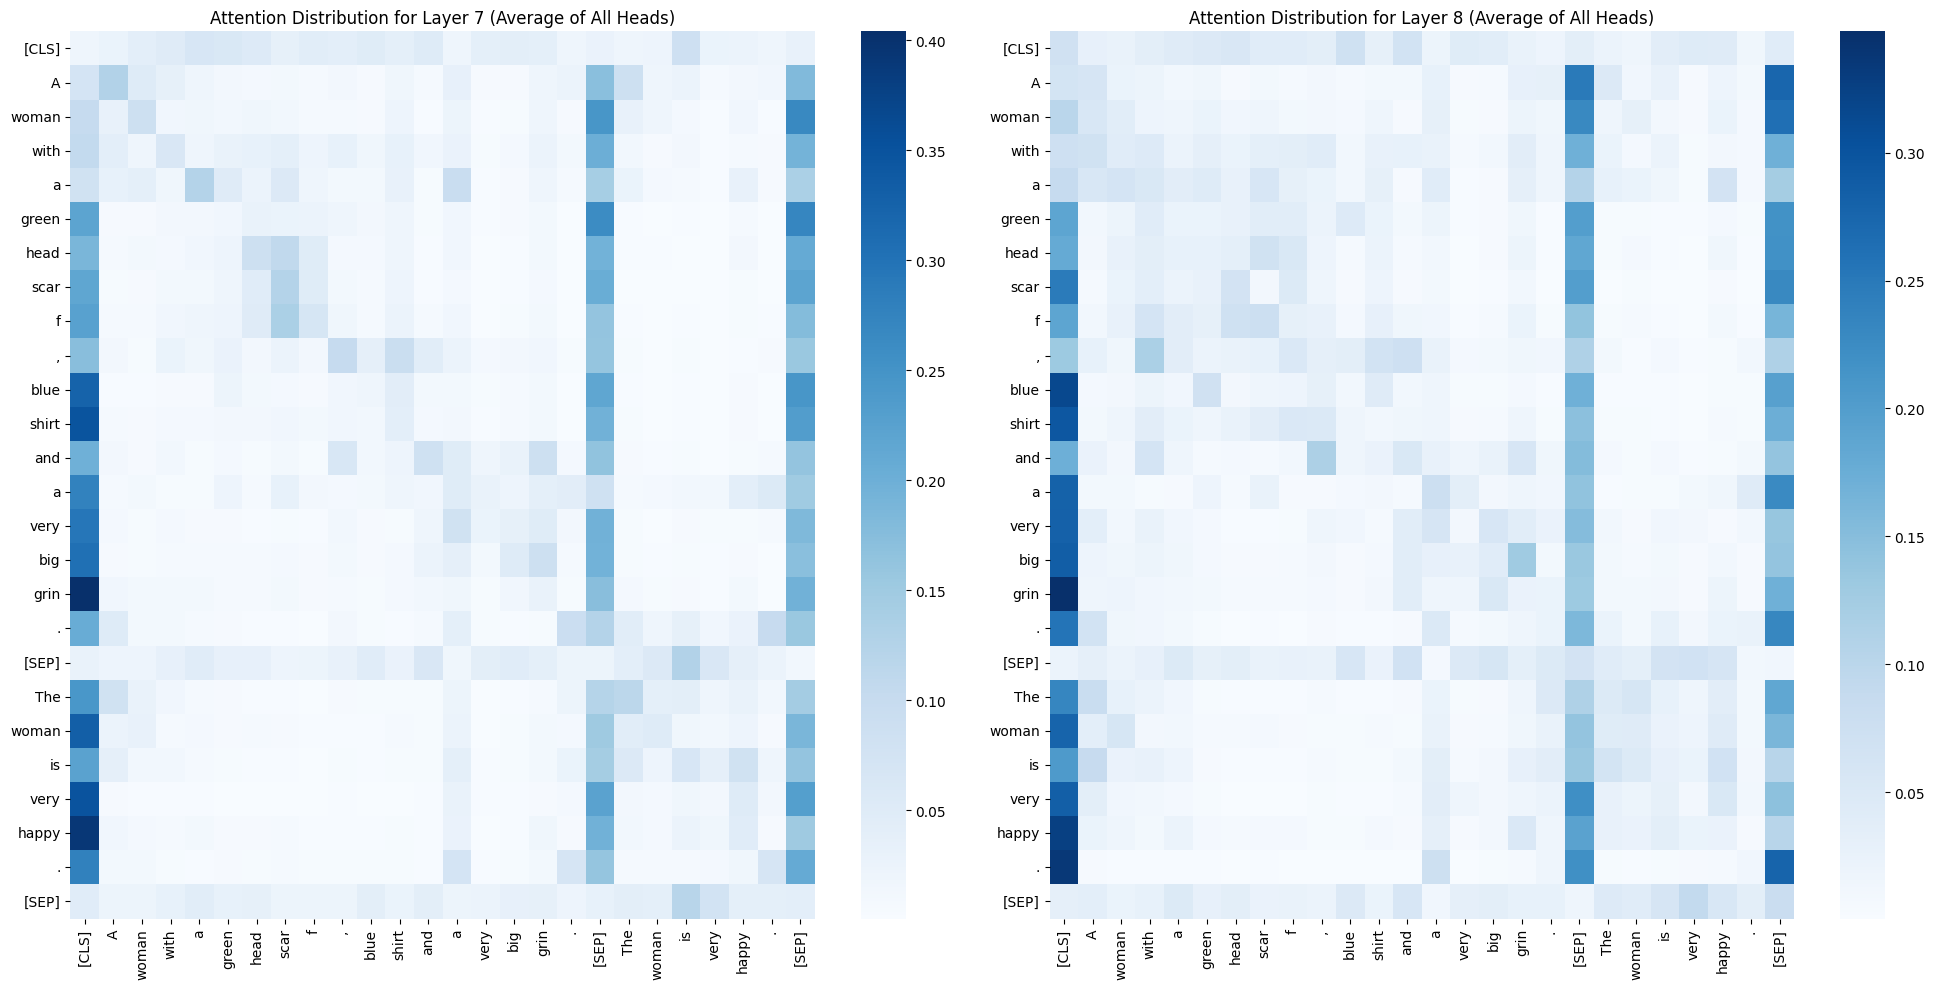

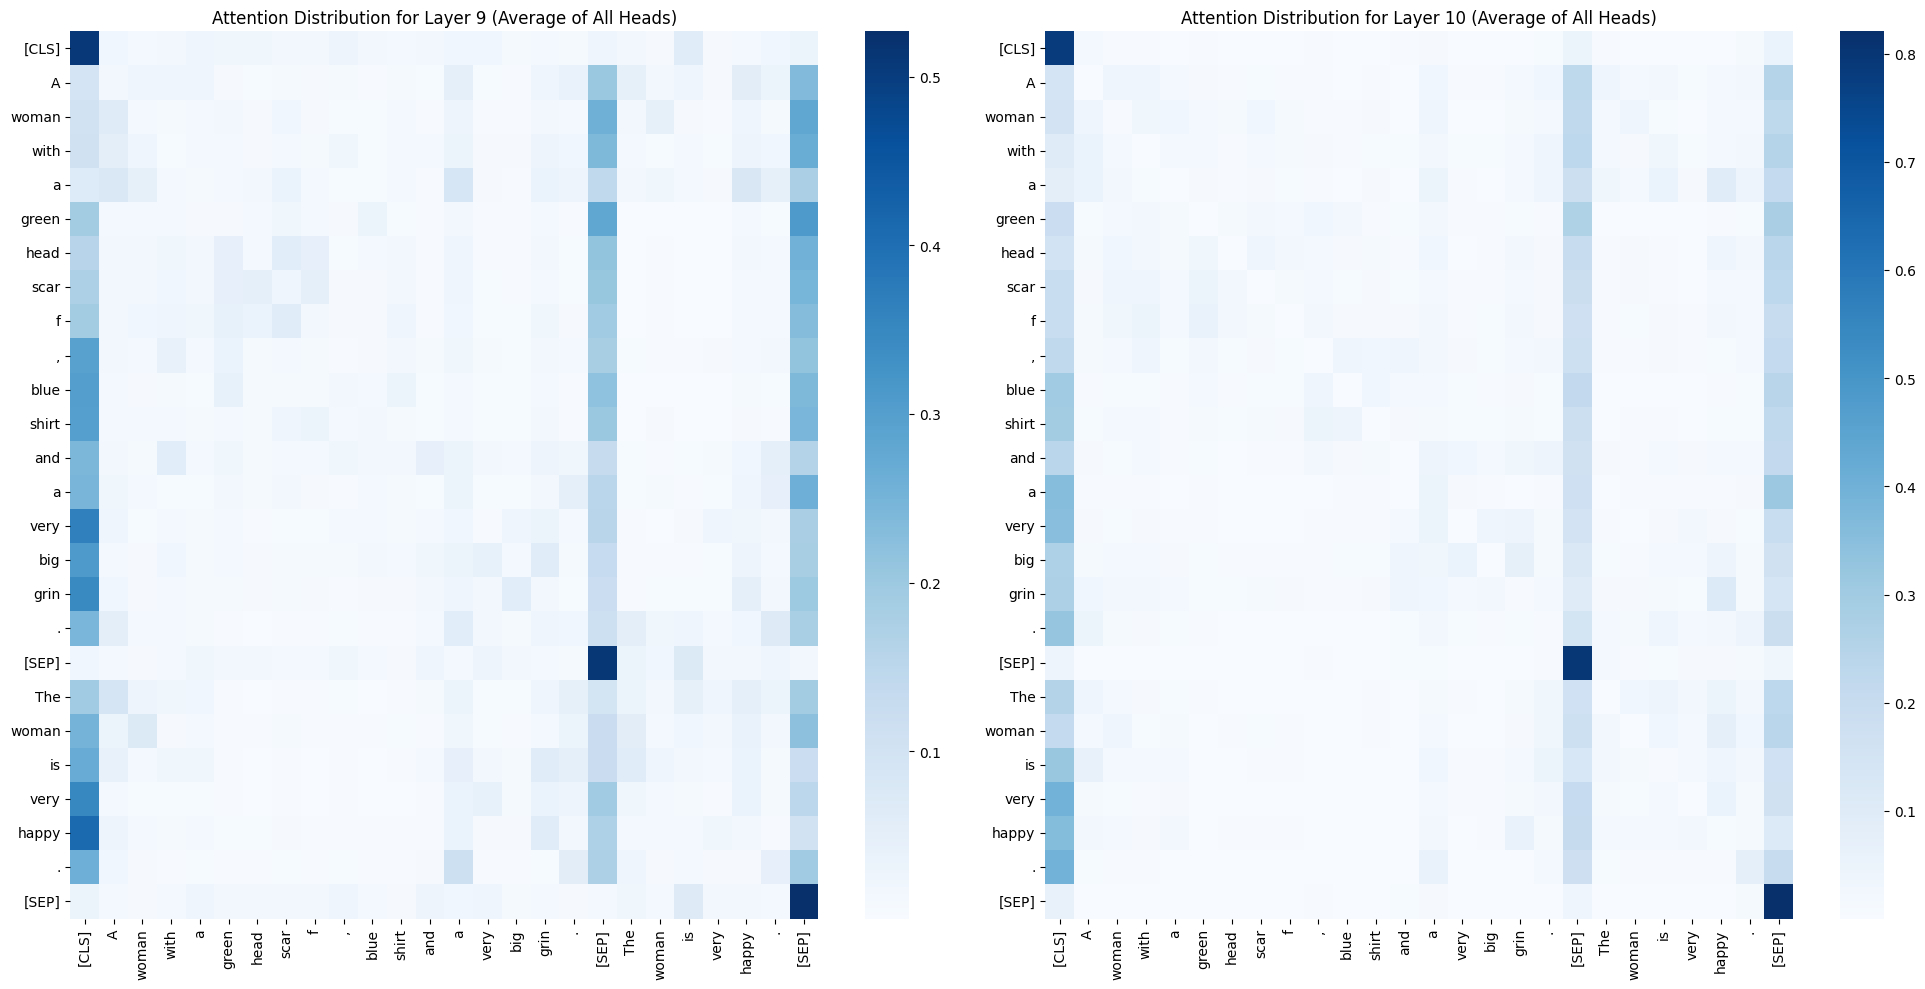

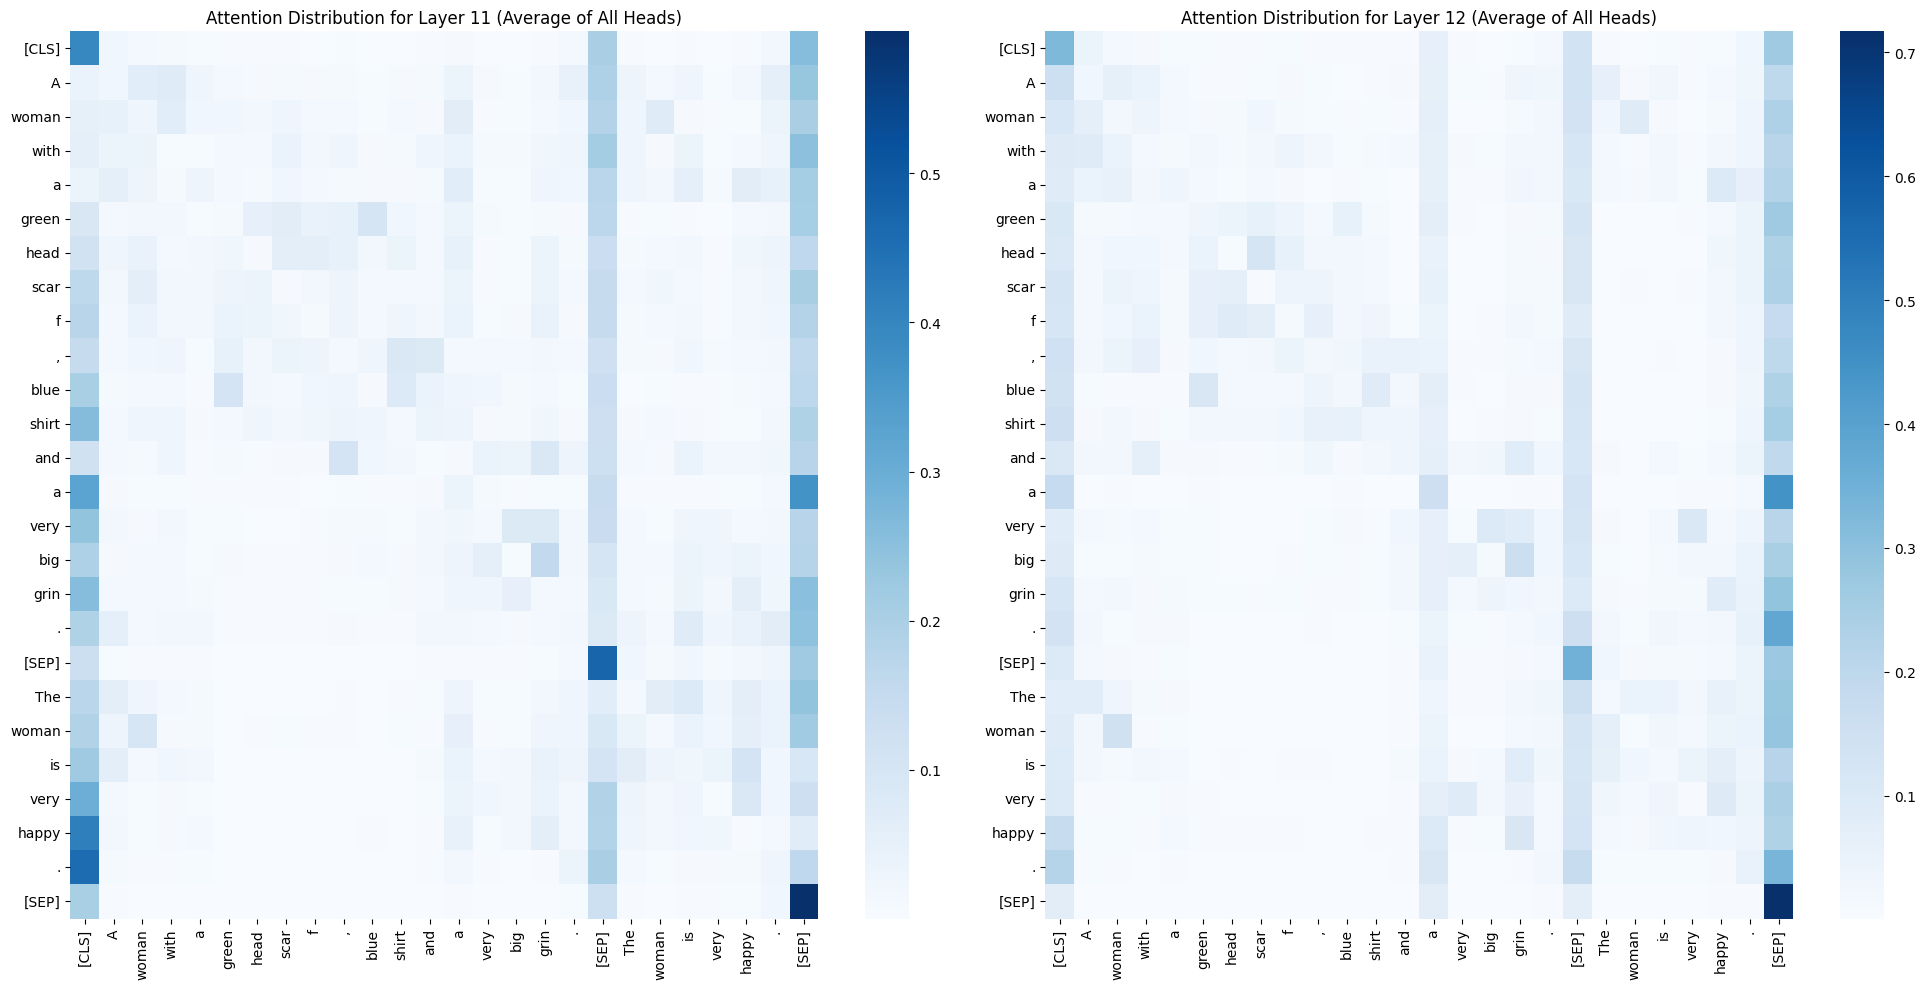

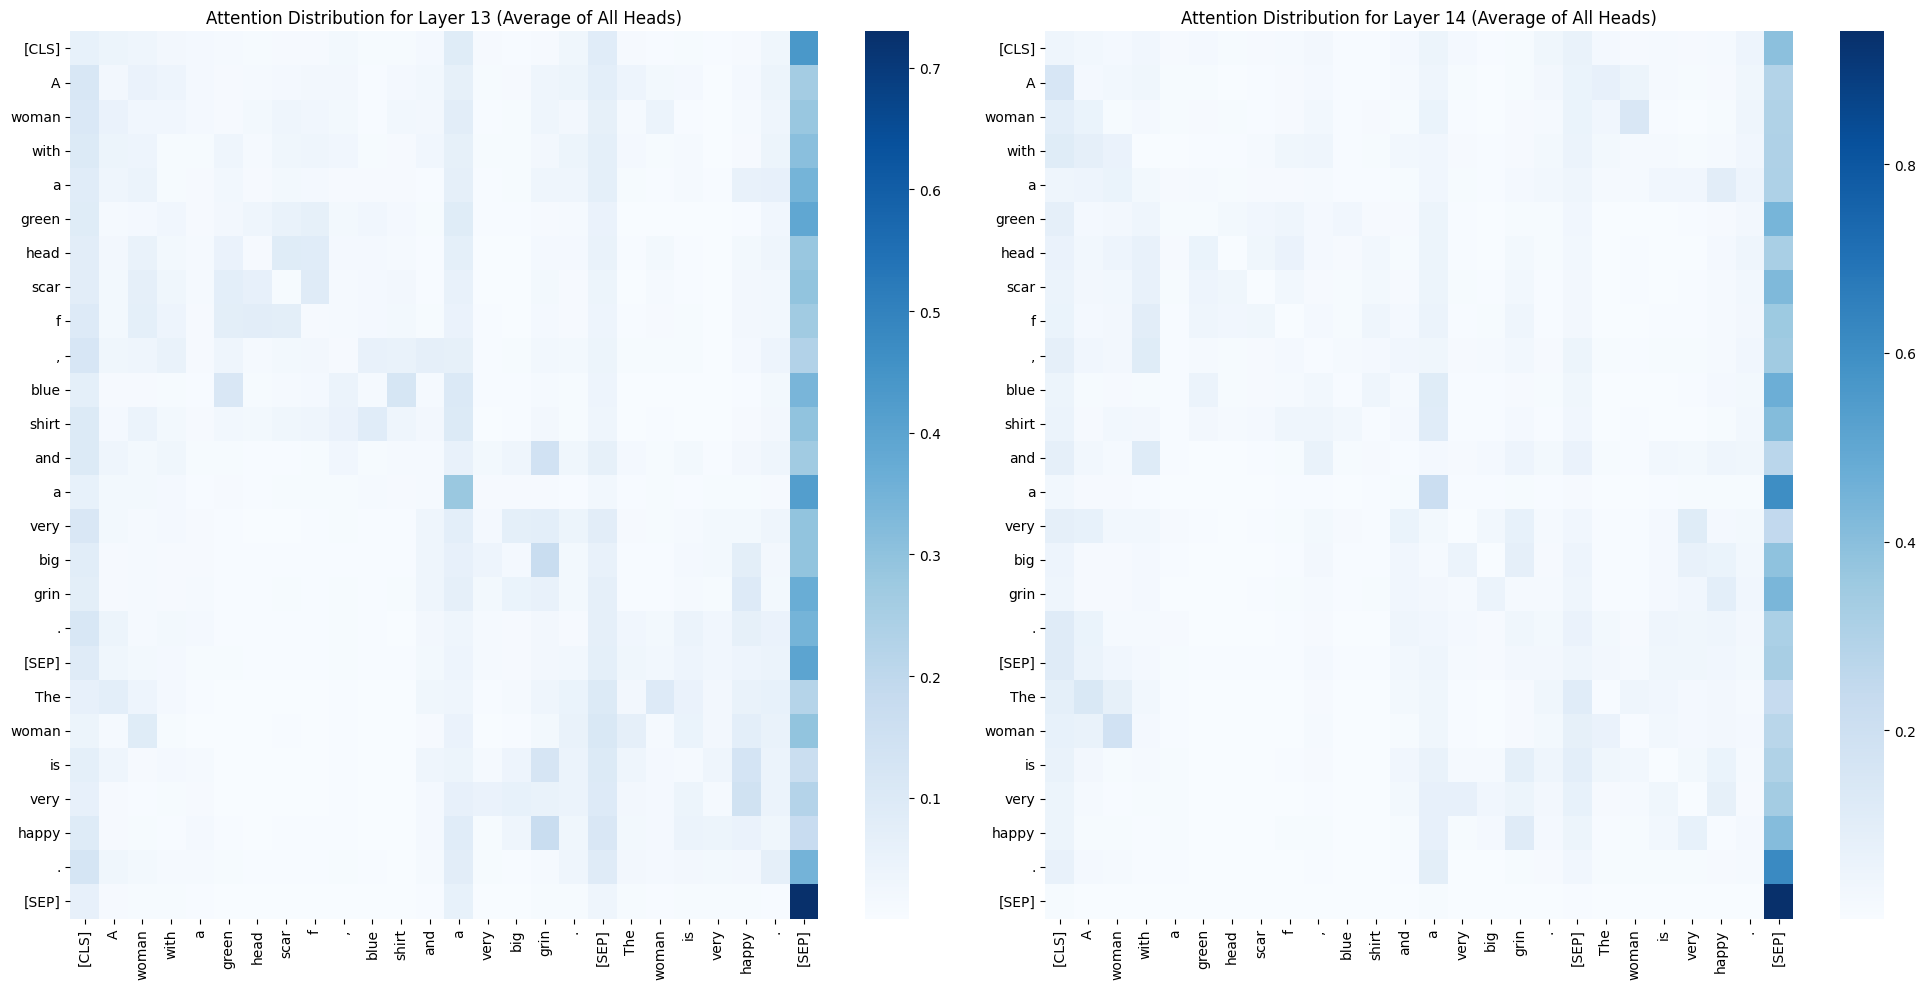

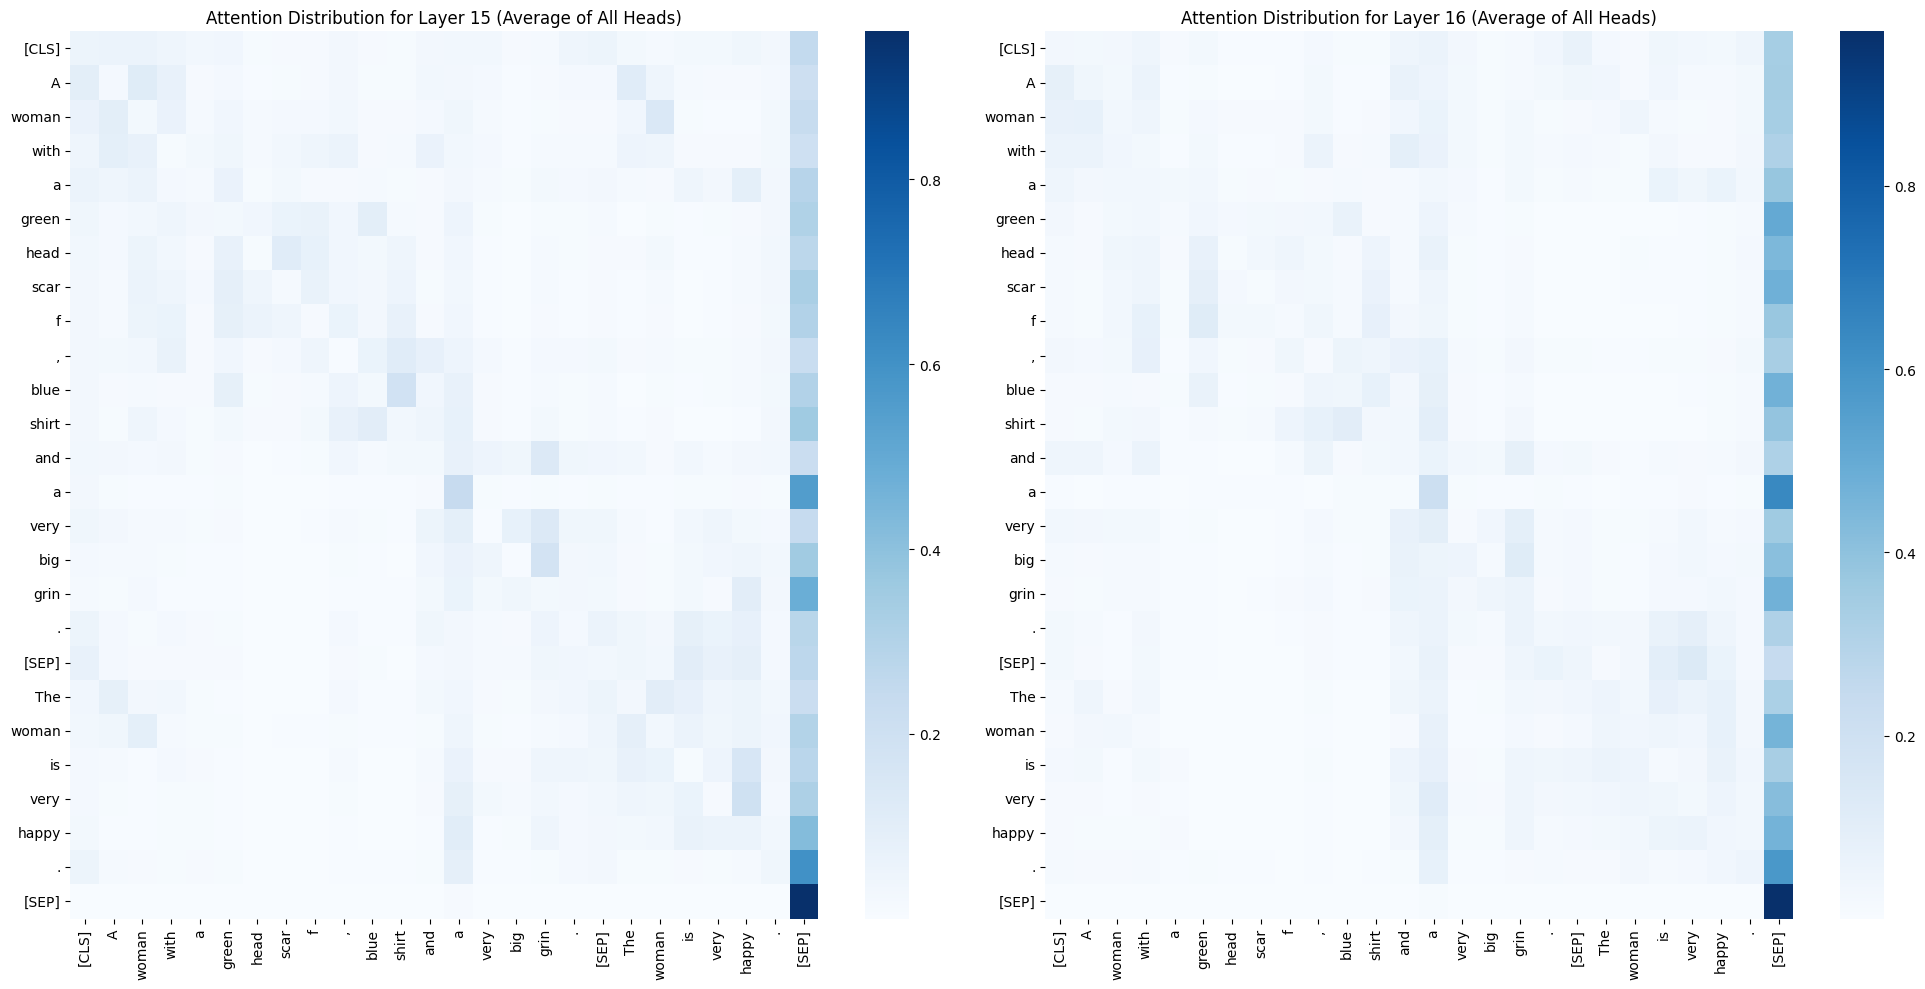

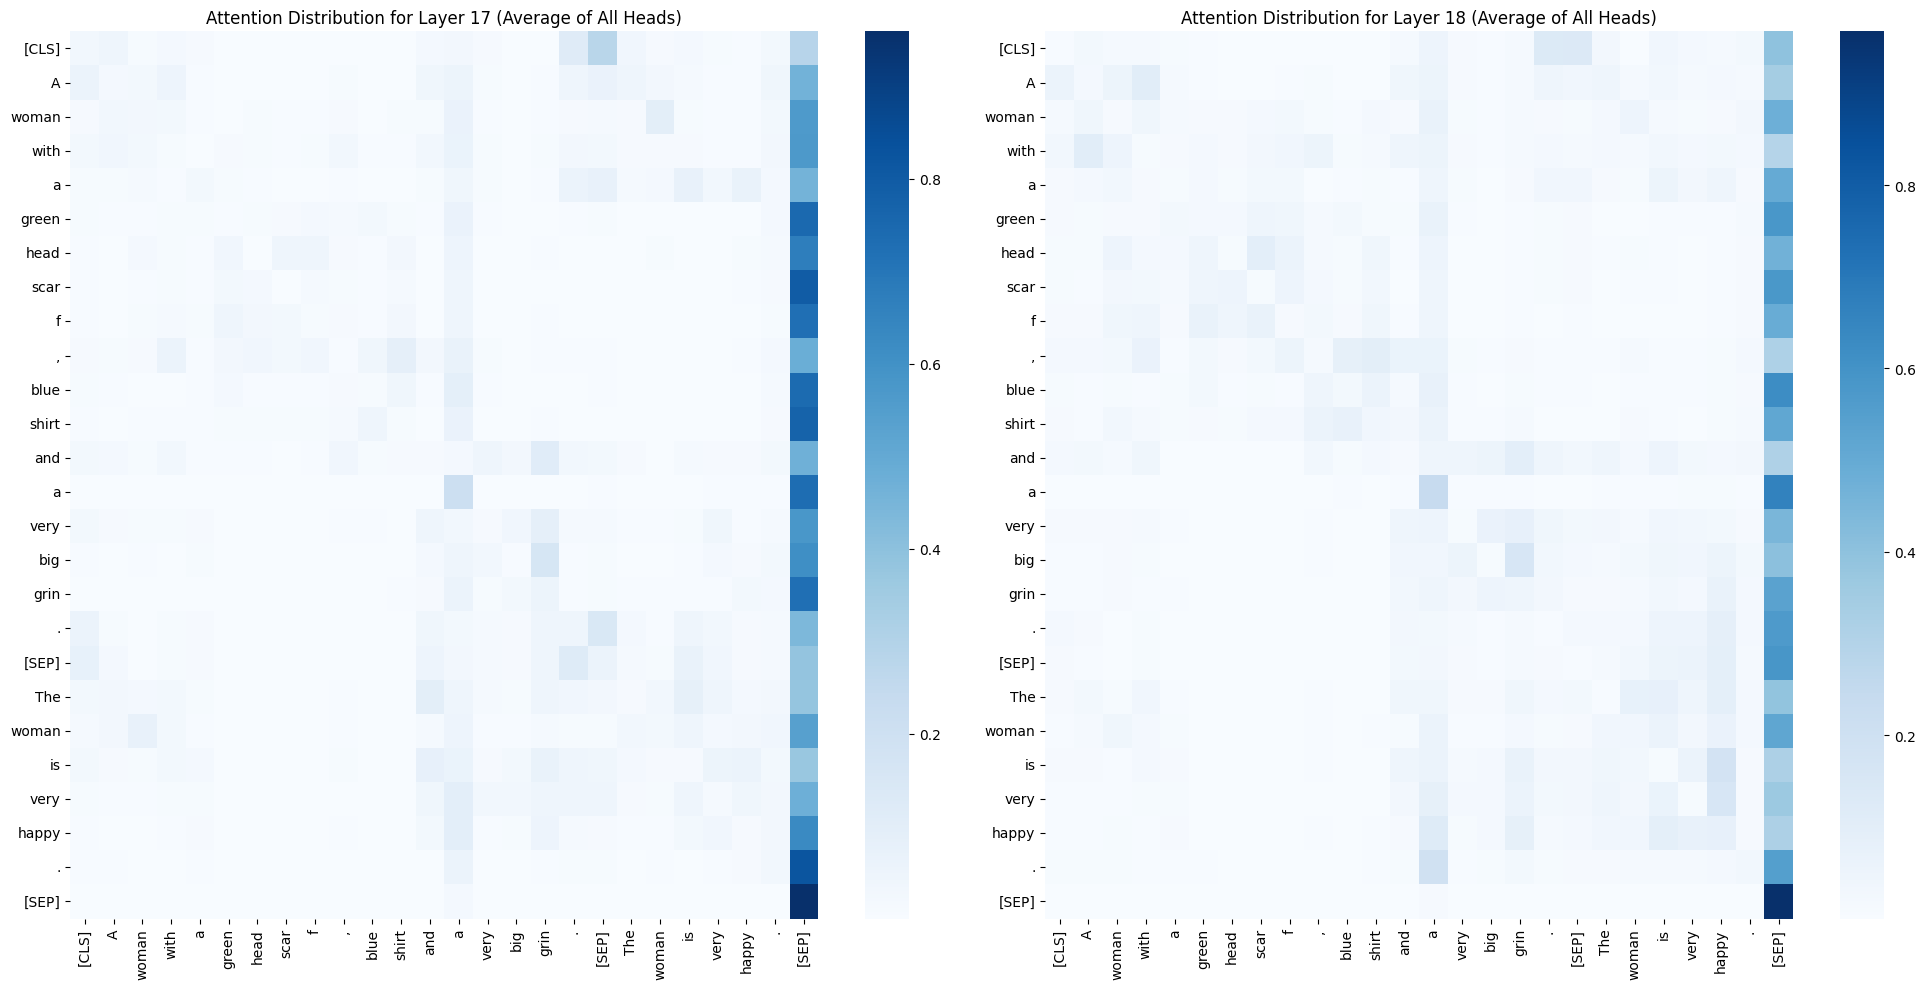

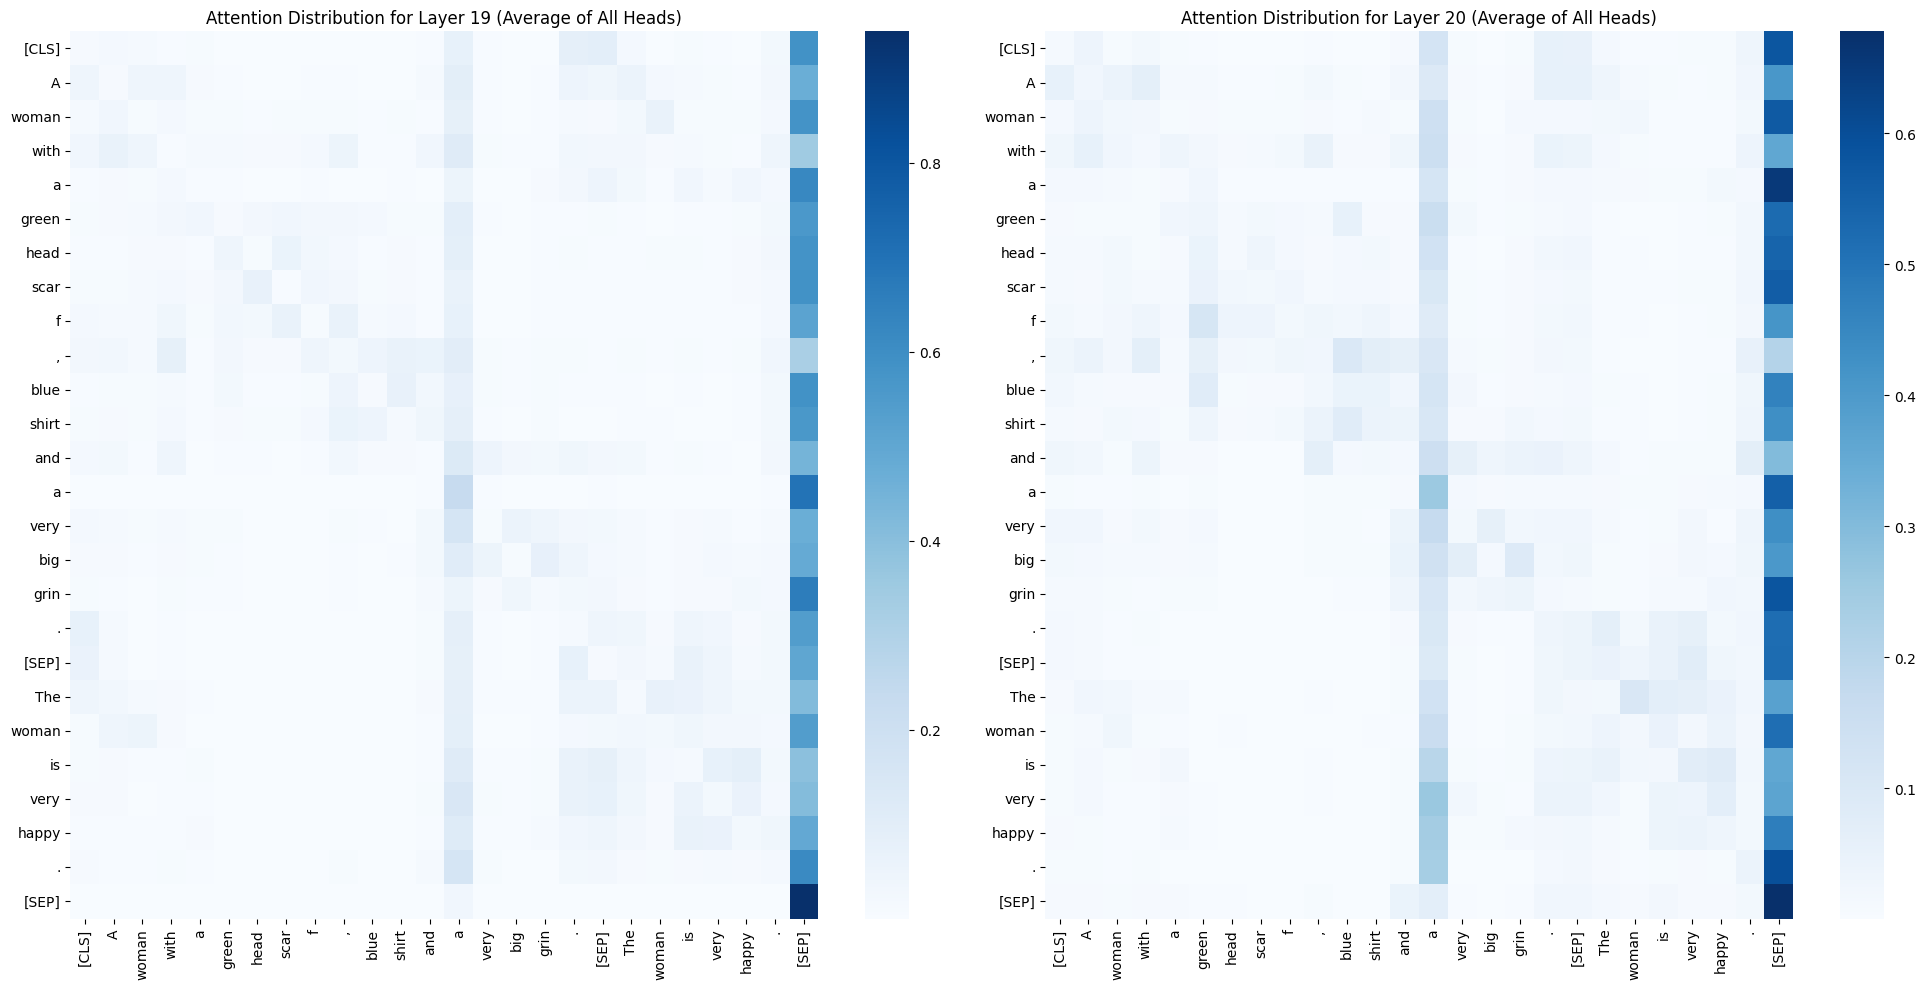

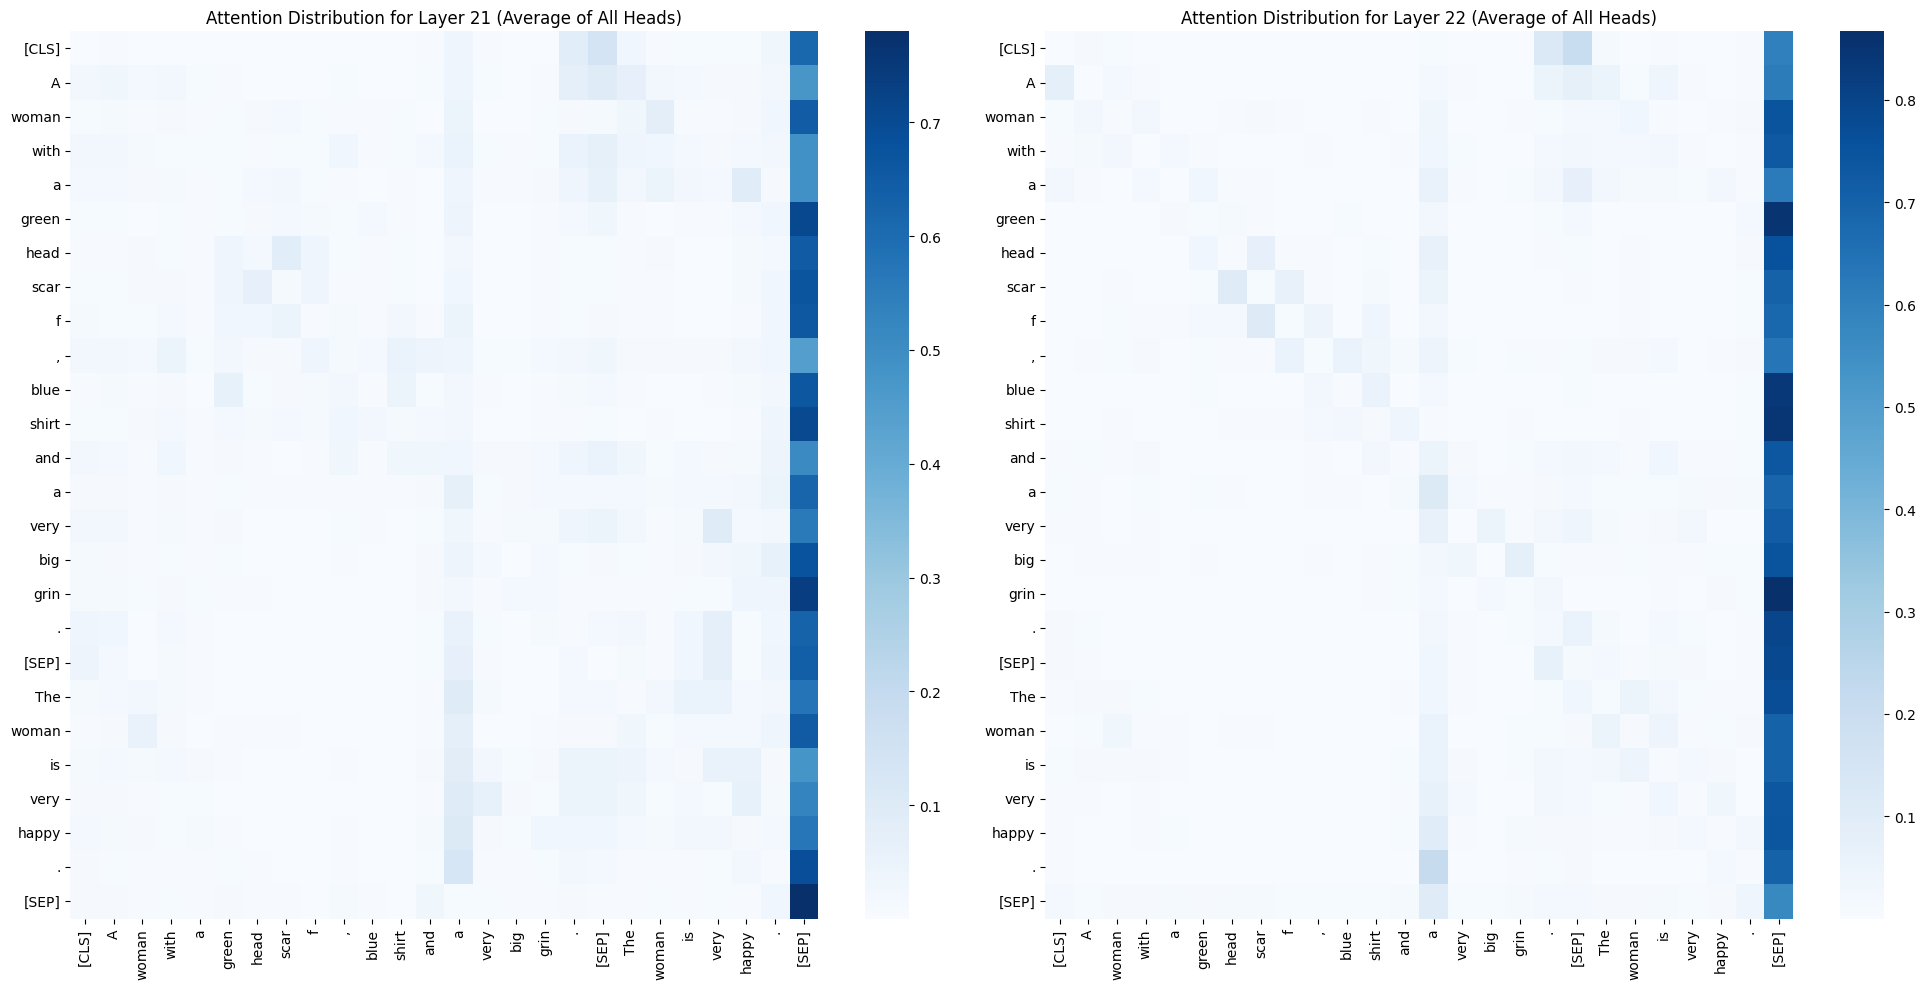

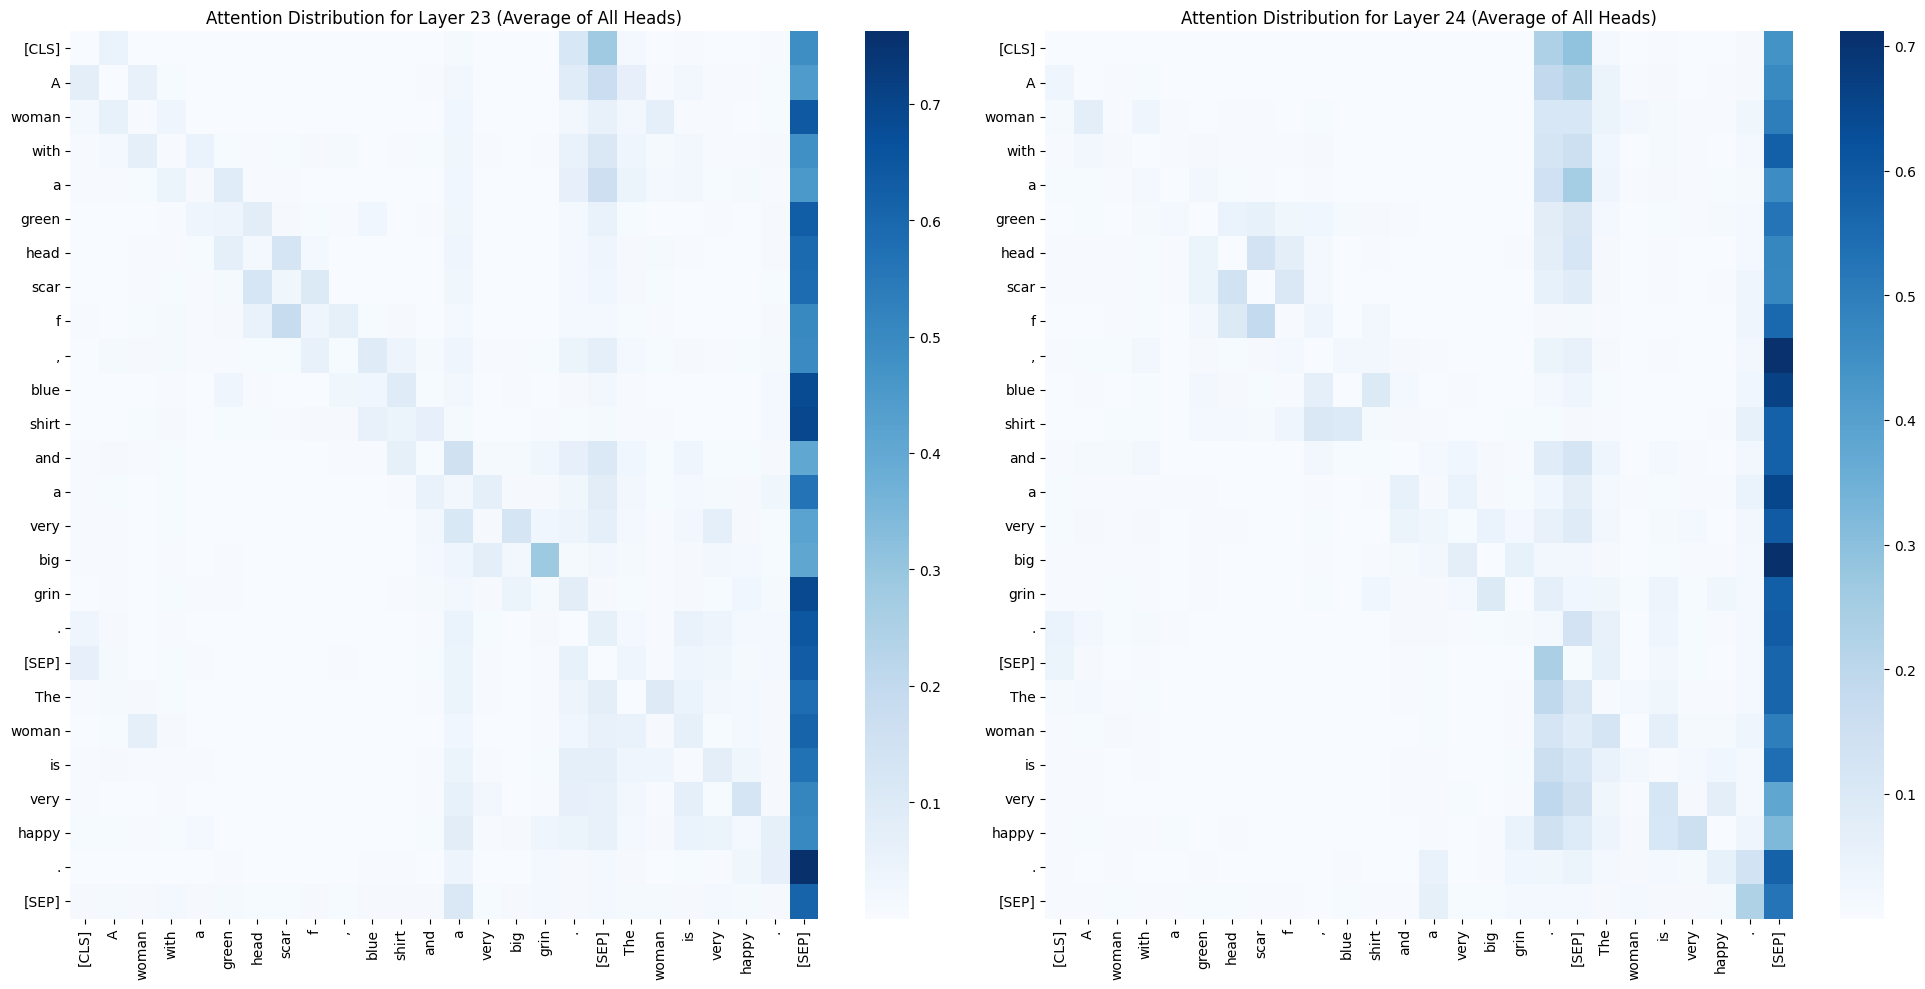

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to clean tokens by removing prefixes
def clean_tokens(tokens):
    cleaned_tokens = []
    for token in tokens:
        # Remove any special characters or prefixes (if relevant)
        if token.startswith("Ġ"):  # Common prefix in tokenizers like RoBERTa or GPT-2
            token = token[1:]  # Remove leading Ġ
        cleaned_tokens.append(token)
    return cleaned_tokens

# Update your visualization function to apply this cleaning step
def visualize_attention(attentions, tokens, layers_per_figure=2):
    tokens = clean_tokens(tokens)  # Apply the cleaning function
    num_layers = len(attentions)  # Total number of layers
    num_heads = attentions[0].shape[1]  # Total number of attention heads

    # Iterate through the layers, showing 2 layers per figure
    for i in range(0, num_layers, layers_per_figure):
        fig, axs = plt.subplots(1, layers_per_figure, figsize=(20, 10))
        
        for j in range(min(layers_per_figure, num_layers - i)):  # Ensure we don't exceed the number of layers
            layer = i + j
            attention_avg = attentions[layer].mean(dim=1).squeeze(0).cpu().numpy()

            sns.heatmap(attention_avg, xticklabels=tokens, yticklabels=tokens, cmap="Blues", annot=False, ax=axs[j])
            axs[j].set_title(f"Attention Distribution for Layer {layer + 1} (Average of All Heads)")
            axs[j].tick_params(axis='x', rotation=90)
            axs[j].tick_params(axis='y', rotation=0)
        
        plt.tight_layout()
        plt.show()

# Function to explain the model's decision and visualize attention across layers
def explain_attention_across_layers(premise, hypothesis, model, tokenizer):
    # Tokenize and prepare inputs
    inputs = tokenizer(premise, hypothesis, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    
    # Get hidden states and attention weights across layers
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # Extract attention scores
        final_logits = outputs.logits  # Final logits for the last layer
    
    # Get the final predicted label
    predicted_label_idx = torch.argmax(final_logits, dim=-1).cpu().item()
    predicted_label = ['contradiction', 'neutral', 'entailment'][predicted_label_idx]
    
    # Decode tokens for attention visualization
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))
    
    # Print final prediction
    print(f"Model Final Prediction: {predicted_label}")
    
    # Visualize attention across all layers, showing 2 layers at a time
    visualize_attention(attentions, tokens, layers_per_figure=2)

# Sample data
sample_number = 5
sample_text = df_snli.iloc[sample_number - 1]  # Subtract 1 because DataFrame is zero-indexed
premise = sample_text['sentence1']
hypothesis = sample_text['sentence2']

# Analyze and visualize attention distribution across layers
explain_attention_across_layers(premise, hypothesis, model, tokenizer)


Model Final Prediction: entailment
First incorrect prediction at Layer 1


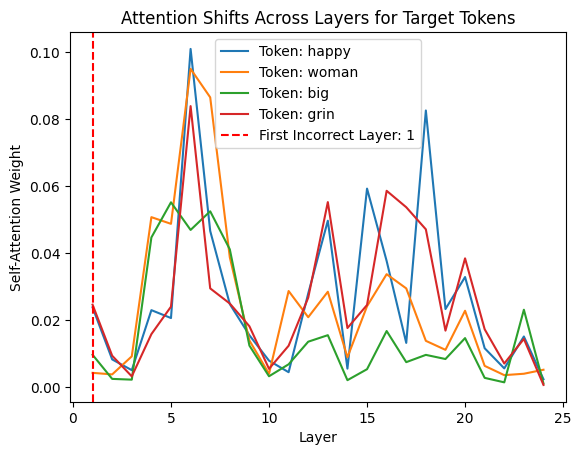

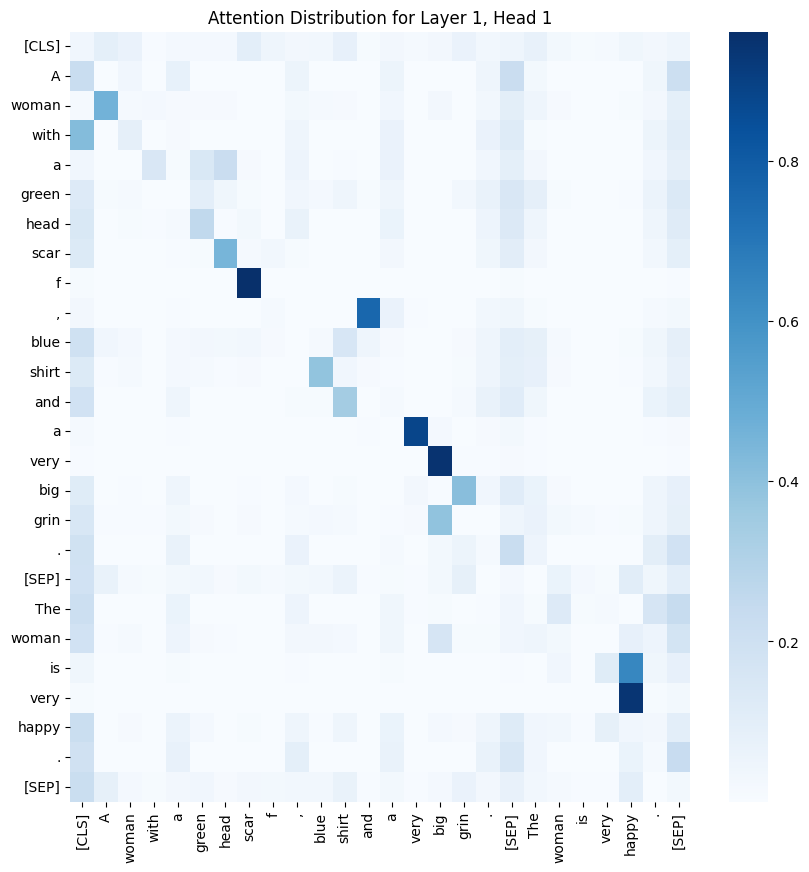

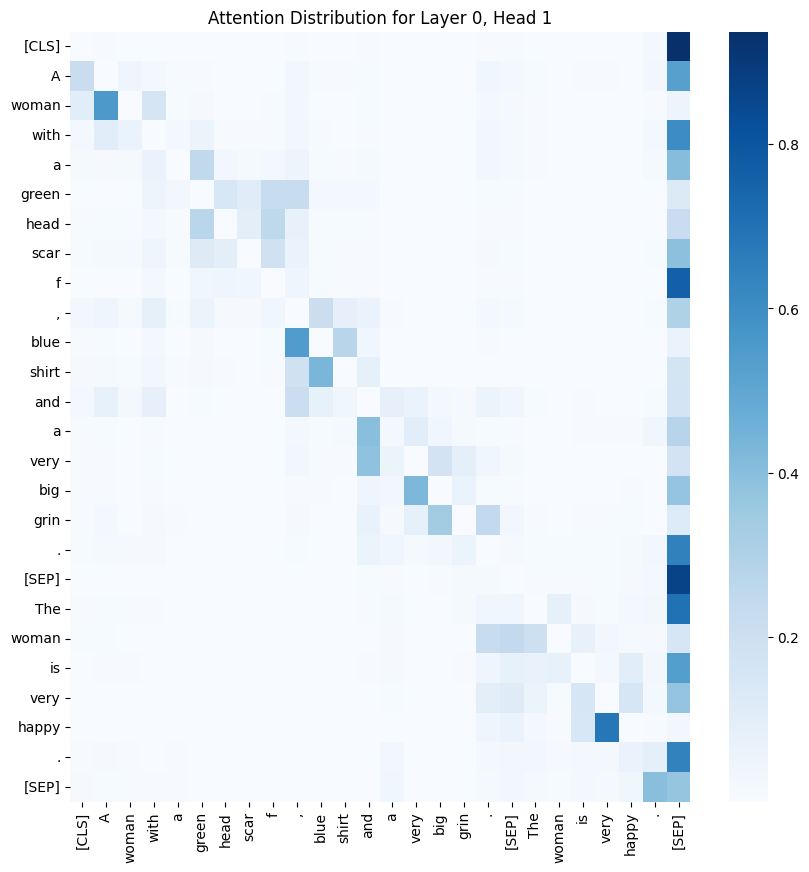

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to clean tokens by removing prefixes
def clean_tokens(tokens):
    cleaned_tokens = []
    for token in tokens:
        # Remove any special characters or prefixes (if relevant)
        if token.startswith("Ġ"):  # Common prefix in tokenizers like RoBERTa or GPT-2
            token = token[1:]  # Remove leading Ġ
        cleaned_tokens.append(token)
    return cleaned_tokens

# Function to track attention of specific tokens across layers
def track_attention_on_tokens(attentions, tokens, target_token_indices):
    num_layers = len(attentions)  # Total number of layers
    num_heads = attentions[0].shape[1]  # Total number of attention heads

    # Average attention for each token at each layer
    attention_across_layers = np.zeros((num_layers, len(target_token_indices)))

    # Iterate through each layer
    for layer in range(num_layers):
        attention_avg = attentions[layer].mean(dim=1).squeeze(0).cpu().numpy()  # Average across heads
        for idx, token_idx in enumerate(target_token_indices):
            # Track attention to the token at each layer
            attention_across_layers[layer, idx] = attention_avg[token_idx, token_idx]  # Self-attention of the token
    
    return attention_across_layers

# Function to explain the model's decision and track attention shifts
def explain_and_track_attention(premise, hypothesis, target_tokens, model, tokenizer):
    # Tokenize and prepare inputs
    inputs = tokenizer(premise, hypothesis, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    
    # Get hidden states and attention weights across layers
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # Extract attention scores
        hidden_states = outputs.hidden_states  # Extract hidden states for each layer
        final_logits = outputs.logits  # Final logits for the last layer
    
    # Get the final predicted label
    predicted_label_idx = torch.argmax(final_logits, dim=-1).cpu().item()
    predicted_label = ['contradiction', 'neutral', 'entailment'][predicted_label_idx]
    
    # Decode tokens for attention visualization
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))
    tokens = clean_tokens(tokens)  # Clean tokens
    
    # Print final prediction
    print(f"Model Final Prediction: {predicted_label}")
    
    # Identify where the model starts making incorrect predictions
    label_map = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
    true_label_idx = label_map[sample_text['gold_label']]
    
    # Find the layer where the first incorrect prediction happens
    incorrect_layer = None
    for layer_idx in range(len(hidden_states)):
        cls_hidden_state = hidden_states[layer_idx][:, 0, :]
        intermediate_logits = model.classifier(cls_hidden_state)
        predicted_label_at_layer = torch.argmax(intermediate_logits, dim=-1).cpu().item()
        
        if predicted_label_at_layer != true_label_idx:
            incorrect_layer = layer_idx + 1  # Found the first incorrect layer
            print(f"First incorrect prediction at Layer {incorrect_layer}")
            break
    
    # If there's no incorrect prediction, the model is correct throughout
    if incorrect_layer is None:
        print("Model makes correct predictions in all layers.")
        incorrect_layer = len(hidden_states)  # Use the last layer if the model is correct

    # Target tokens to track (important tokens)
    target_token_indices = [tokens.index(token) for token in target_tokens if token in tokens]
    
    # Track attention on important tokens across layers
    attention_across_layers = track_attention_on_tokens(attentions, tokens, target_token_indices)
    
    # Visualize attention shifts for these tokens
    for idx, token in enumerate(target_tokens):
        if token in tokens:
            plt.plot(range(1, len(attentions) + 1), attention_across_layers[:, idx], label=f"Token: {token}")
    
    plt.axvline(x=incorrect_layer, color='r', linestyle='--', label=f"First Incorrect Layer: {incorrect_layer}")
    plt.xlabel("Layer")
    plt.ylabel("Self-Attention Weight")
    plt.title("Attention Shifts Across Layers for Target Tokens")
    plt.legend()
    plt.show()

    # Visualize attention heatmaps for the first incorrect layer and the last correct layer
    if incorrect_layer:
        visualize_attention(attentions, tokens, layer=incorrect_layer - 1)
    visualize_attention(attentions, tokens, layer=incorrect_layer - 2)

# Function to visualize attention distribution across layers and heads
def visualize_attention(attentions, tokens, layer=0, head=0):
    tokens = clean_tokens(tokens)  # Clean tokens before visualization
    # Extract attention for the specific layer and head
    attention = attentions[layer][0, head].cpu().numpy()
    
    # Create a heatmap for the attention scores
    plt.figure(figsize=(10, 10))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap="Blues", annot=False)
    plt.title(f"Attention Distribution for Layer {layer + 1}, Head {head + 1}")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Sample data
sample_number = 5
sample_text = df_snli.iloc[sample_number - 1]  # Subtract 1 because DataFrame is zero-indexed
premise = sample_text['sentence1']
hypothesis = sample_text['sentence2']

# Target tokens to track ("happy", "grin", "woman", "very", "big")
target_tokens = ["happy","woman","big","grin"]

# Analyze and visualize attention distribution and track attention on specific tokens
explain_and_track_attention(premise, hypothesis, target_tokens, model, tokenizer)

